/tmp/ipykernel_1110327/3893661619.py:212: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Illustration saved to 'spatial_alignment_nature_style.svg'


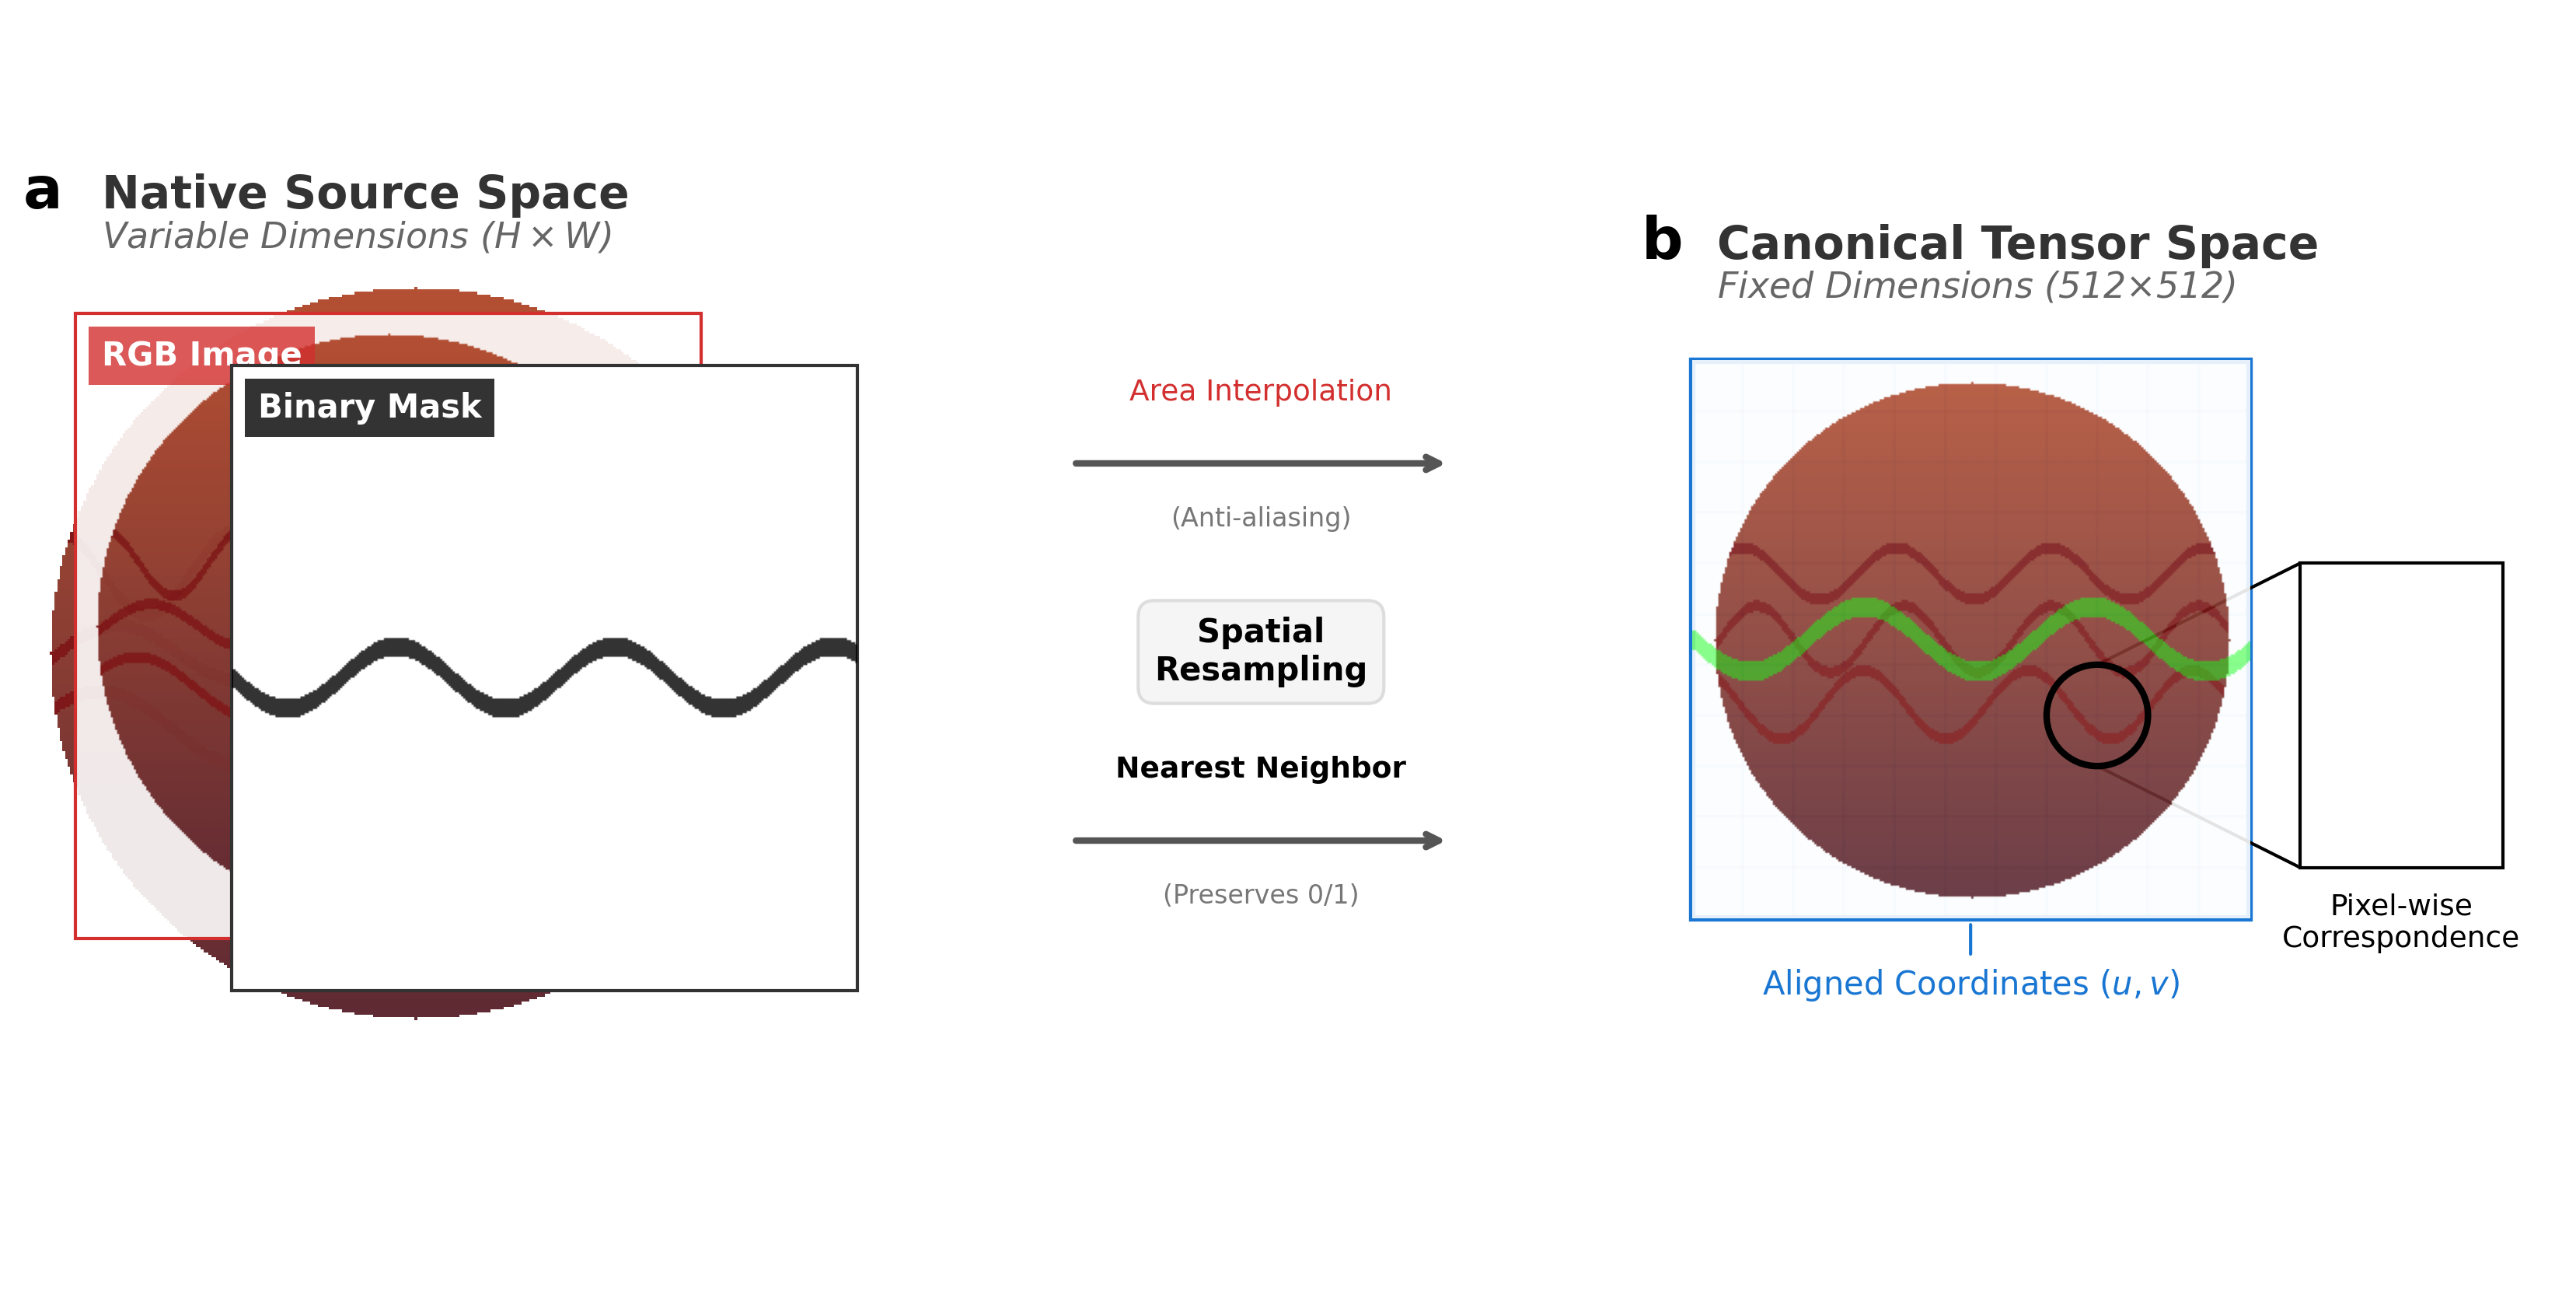

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
import numpy as np

def create_synthetic_fundus(shape=(200, 200)):
    """Generates a schematic 'fundus-like' image pattern."""
    h, w = shape
    y, x = np.ogrid[:h, :w]
    center = (h//2, w//2)
    radius = min(h, w) // 2 - 10
    
    # Circular mask
    mask = (x - center[1])**2 + (y - center[0])**2 <= radius**2
    
    # Base retina color (orange-red gradient)
    img = np.zeros((h, w, 3))
    # Gradient background
    grad = np.linspace(0.8, 0.4, h)[:, None]
    img[:, :, 0] = 0.9  * grad.flatten().reshape(h, 1) # R
    img[:, :, 1] = 0.4 * grad.flatten().reshape(h, 1)  # G
    img[:, :, 2] = 0.2  # B
    
    # Add 'vessels' (simple sine waves)
    for i in range(3):
        phase = np.random.rand() * 2 * np.pi
        amp = 10 + np.random.rand() * 10
        freq = 0.05 + np.random.rand() * 0.05
        
        vx = np.arange(w)
        vy = (h//2) + amp * np.sin(vx * freq + phase) + (i - 1) * 30
        
        # Draw vessel lines thicker
        for offset in range(-2, 3):
            valid = (vy + offset).astype(int)
            valid_x = vx[(valid >= 0) & (valid < h)]
            valid_y = valid[(valid >= 0) & (valid < h)]
            img[valid_y, valid_x, :] = [0.5, 0.1, 0.1]

    # Apply circular crop
    bg_color = [1, 1, 1]
    img[~mask] = bg_color
    
    return img

def create_synthetic_mask(shape=(200, 200)):
    """Generates a schematic binary mask corresponding to a 'vessel'."""
    h, w = shape
    mask = np.zeros((h, w))
    
    # Draw a simple vessel-like path
    vx = np.arange(w)
    vy = (h//2) + 15 * np.sin(vx * 0.06)
    
    for offset in range(-4, 5):
        valid = (vy + offset).astype(int)
        valid_x = vx[(valid >= 0) & (valid < h)]
        valid_y = valid[(valid >= 0) & (valid < h)]
        mask[valid_y, valid_x] = 1
        
    return mask

def draw_grid(ax, shape, step=20, color='gray', alpha=0.2):
    """Overlays a grid to represent tensor space."""
    h, w = shape
    for x in range(0, w, step):
        ax.axvline(x, color=color, alpha=alpha, linestyle='-', linewidth=0.5)
    for y in range(0, h, step):
        ax.axhline(y, color=color, alpha=alpha, linestyle='-', linewidth=0.5)

def plot_illustration():
    # Setup Figure
    fig = plt.figure(figsize=(14, 7), dpi=300)
    # Background color white
    fig.patch.set_facecolor('white')
    
    # Grid layout: 3 columns (Input, Arrow/Process, Output)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.6, 1], wspace=0.1)
    
    # === PANEL A: INPUT SPACE ===
    ax_in = plt.subplot(gs[0])
    ax_in.axis('off')
    
    # Generate Mock Data
    src_h, src_w = 300, 300
    img_data = create_synthetic_fundus((src_h, src_w))
    mask_data = create_synthetic_mask((src_h, src_w))
    
    # Show Image (Background)
    # Shift image slightly up and left to create "stacking" effect visually
    ax_in.imshow(img_data, extent=[0, src_w, 0, src_h])
    
    # Show Mask (Foreground, offset)
    # We create a separate floating axis or just offset the plot manually?
    # Simpler: Draw patches manually for schematic look
    
    # Let's draw the "Image" card
    rect_img = patches.Rectangle((20, 40), 240, 240, linewidth=1, edgecolor='#d32f2f', facecolor='none', zorder=2)
    ax_in.add_patch(rect_img)
    ax_in.imshow(img_data, extent=[20, 260, 40, 280], alpha=0.9, zorder=1)
    ax_in.text(30, 260, "RGB Image", fontsize=10, color='white', fontweight='bold', bbox=dict(facecolor='#d32f2f', alpha=0.8, edgecolor='none'))

    # Let's draw the "Mask" card overlapping
    offset_x, offset_y = 60, -20
    rect_mask = patches.Rectangle((20 + offset_x, 40 + offset_y), 240, 240, linewidth=1, edgecolor='#333', facecolor='white', zorder=3)
    ax_in.add_patch(rect_mask)
    
    # Create mask overlay with transparency
    mask_display = np.zeros((src_h, src_w, 4))
    mask_display[mask_data == 1] = [0, 0, 0, 0.8] # Black mask
    ax_in.imshow(mask_display, extent=[20+offset_x, 260+offset_x, 40+offset_y, 280+offset_y], zorder=4)
    ax_in.text(30+offset_x, 260+offset_y, "Binary Mask", fontsize=10, color='white', fontweight='bold', bbox=dict(facecolor='black', alpha=0.8, edgecolor='none'))
    
    # Labels
    ax_in.text(0, 320, "a", fontsize=18, fontweight='bold')
    ax_in.text(30, 320, "Native Source Space", fontsize=14, fontweight='bold', color='#333')
    ax_in.text(30, 305, "Variable Dimensions ($H \\times W$)", fontsize=11, color='#666', style='italic')
    
    ax_in.set_xlim(0, 350)
    ax_in.set_ylim(-50, 350)

    # === PANEL B: PROCESS (Arrows) ===
    ax_mid = plt.subplot(gs[1])
    ax_mid.axis('off')
    ax_mid.set_xlim(0, 100)
    ax_mid.set_ylim(0, 100)
    
    # Top arrow (Image)
    ax_mid.annotate("", xy=(80, 65), xytext=(10, 65),
                    arrowprops=dict(arrowstyle="->", color="#555", lw=2))
    ax_mid.text(45, 70, "Area Interpolation", ha='center', fontsize=9, color='#d32f2f')
    ax_mid.text(45, 60, "(Anti-aliasing)", ha='center', fontsize=8, color='#777')

    # Bottom arrow (Mask)
    ax_mid.annotate("", xy=(80, 35), xytext=(10, 35),
                    arrowprops=dict(arrowstyle="->", color="#555", lw=2))
    ax_mid.text(45, 40, "Nearest Neighbor", ha='center', fontsize=9, color='black', fontweight='bold')
    ax_mid.text(45, 30, "(Preserves 0/1)", ha='center', fontsize=8, color='#777')
    
    ax_mid.text(45, 50, "Spatial\nResampling", ha='center', va='center', fontsize=10, fontweight='bold', 
                bbox=dict(boxstyle="round,pad=0.5", fc="#f5f5f5", ec="#ddd"))

    # === PANEL C: OUTPUT SPACE ===
    ax_out = plt.subplot(gs[2])
    ax_out.axis('off')
    
    tgt_dim = 256
    img_resized = create_synthetic_fundus((tgt_dim, tgt_dim)) # Smaller
    mask_resized = create_synthetic_mask((tgt_dim, tgt_dim))
    
    # Draw the Aligned Tensor (Stacked representation)
    
    # Grid background (The Tensor)
    rect_tensor = patches.Rectangle((20, 20), 220, 220, linewidth=2, edgecolor='#1976D2', facecolor='#E3F2FD', zorder=1)
    ax_out.add_patch(rect_tensor)
    
    # Draw Grid lines
    for i in range(20, 240, 20):
        ax_out.plot([i, i], [20, 240], color='#1976D2', alpha=0.2, lw=1, zorder=1)
        ax_out.plot([20, 240], [i, i], color='#1976D2', alpha=0.2, lw=1, zorder=1)

    # Show aligned image fading into mask
    # We blend them manually to show "alignment"
    composite = img_resized.copy()
    # Overlay green mask
    mask_indices = mask_resized == 1
    composite[mask_indices] = composite[mask_indices] * 0.5 + np.array([0, 1, 0]) * 0.5
    
    ax_out.imshow(composite, extent=[20, 240, 20, 240], zorder=2, alpha=0.9)
    
    # Decoration
    ax_out.text(0, 280, "b", fontsize=18, fontweight='bold')
    ax_out.text(30, 280, "Canonical Tensor Space", fontsize=14, fontweight='bold', color='#333')
    ax_out.text(30, 265, "Fixed Dimensions (512$\\times$512)", fontsize=11, color='#666', style='italic')

    # Annotate coordinate system
    ax_out.annotate("Aligned Coordinates $(u,v)$", xy=(130, 20), xytext=(130, -10),
                   arrowprops=dict(arrowstyle="-", color="#1976D2"),
                   ha='center', color="#1976D2", fontsize=10)

    # Add a "Pixel" zoom-in bubble
    zoom_circle = patches.Circle((180, 100), 20, fill=False, edgecolor='black', lw=2, zorder=10)
    ax_out.add_patch(zoom_circle)
    
    # Zoom lines
    con1 = ConnectionPatch(xyA=(180, 120), coordsA=ax_out.transData,
                           xyB=(260, 160), coordsB=ax_out.transData, color='black', lw=1)
    con2 = ConnectionPatch(xyA=(180, 80), coordsA=ax_out.transData,
                           xyB=(260, 40), coordsB=ax_out.transData, color='black', lw=1)
    ax_out.add_artist(con1)
    ax_out.add_artist(con2)
    
    # Zoom box
    rect_zoom = patches.Rectangle((260, 40), 80, 120, facecolor='white', edgecolor='black', zorder=10)
    ax_out.add_patch(rect_zoom)
    
    # Draw pixels in zoom
    # 4x4 grid
    for i in range(4):
        for j in range(6):
            # Checkerboard pixel colors
            c = 'green' if (i+j)%3 == 0 else '#ffcccb'
            rect_pix = patches.Rectangle((260 + i*20, 40 + j*20), 20, 20, facecolor=c, edgecolor='white')
            ax_out.add_patch(rect_pix)
            
    ax_out.text(300, 30, "Pixel-wise\nCorrespondence", ha='center', va='top', fontsize=9)

    ax_out.set_xlim(0, 360)
    ax_out.set_ylim(-50, 300)

    plt.tight_layout()
    plt.savefig('spatial_alignment_nature_style.svg', format='svg')
    print("Illustration saved to 'spatial_alignment_nature_style.svg'")

plot_illustration()

/tmp/ipykernel_1110327/1201919645.py:117: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Illustration saved to 'gaussian_lifting_nature_style.svg'


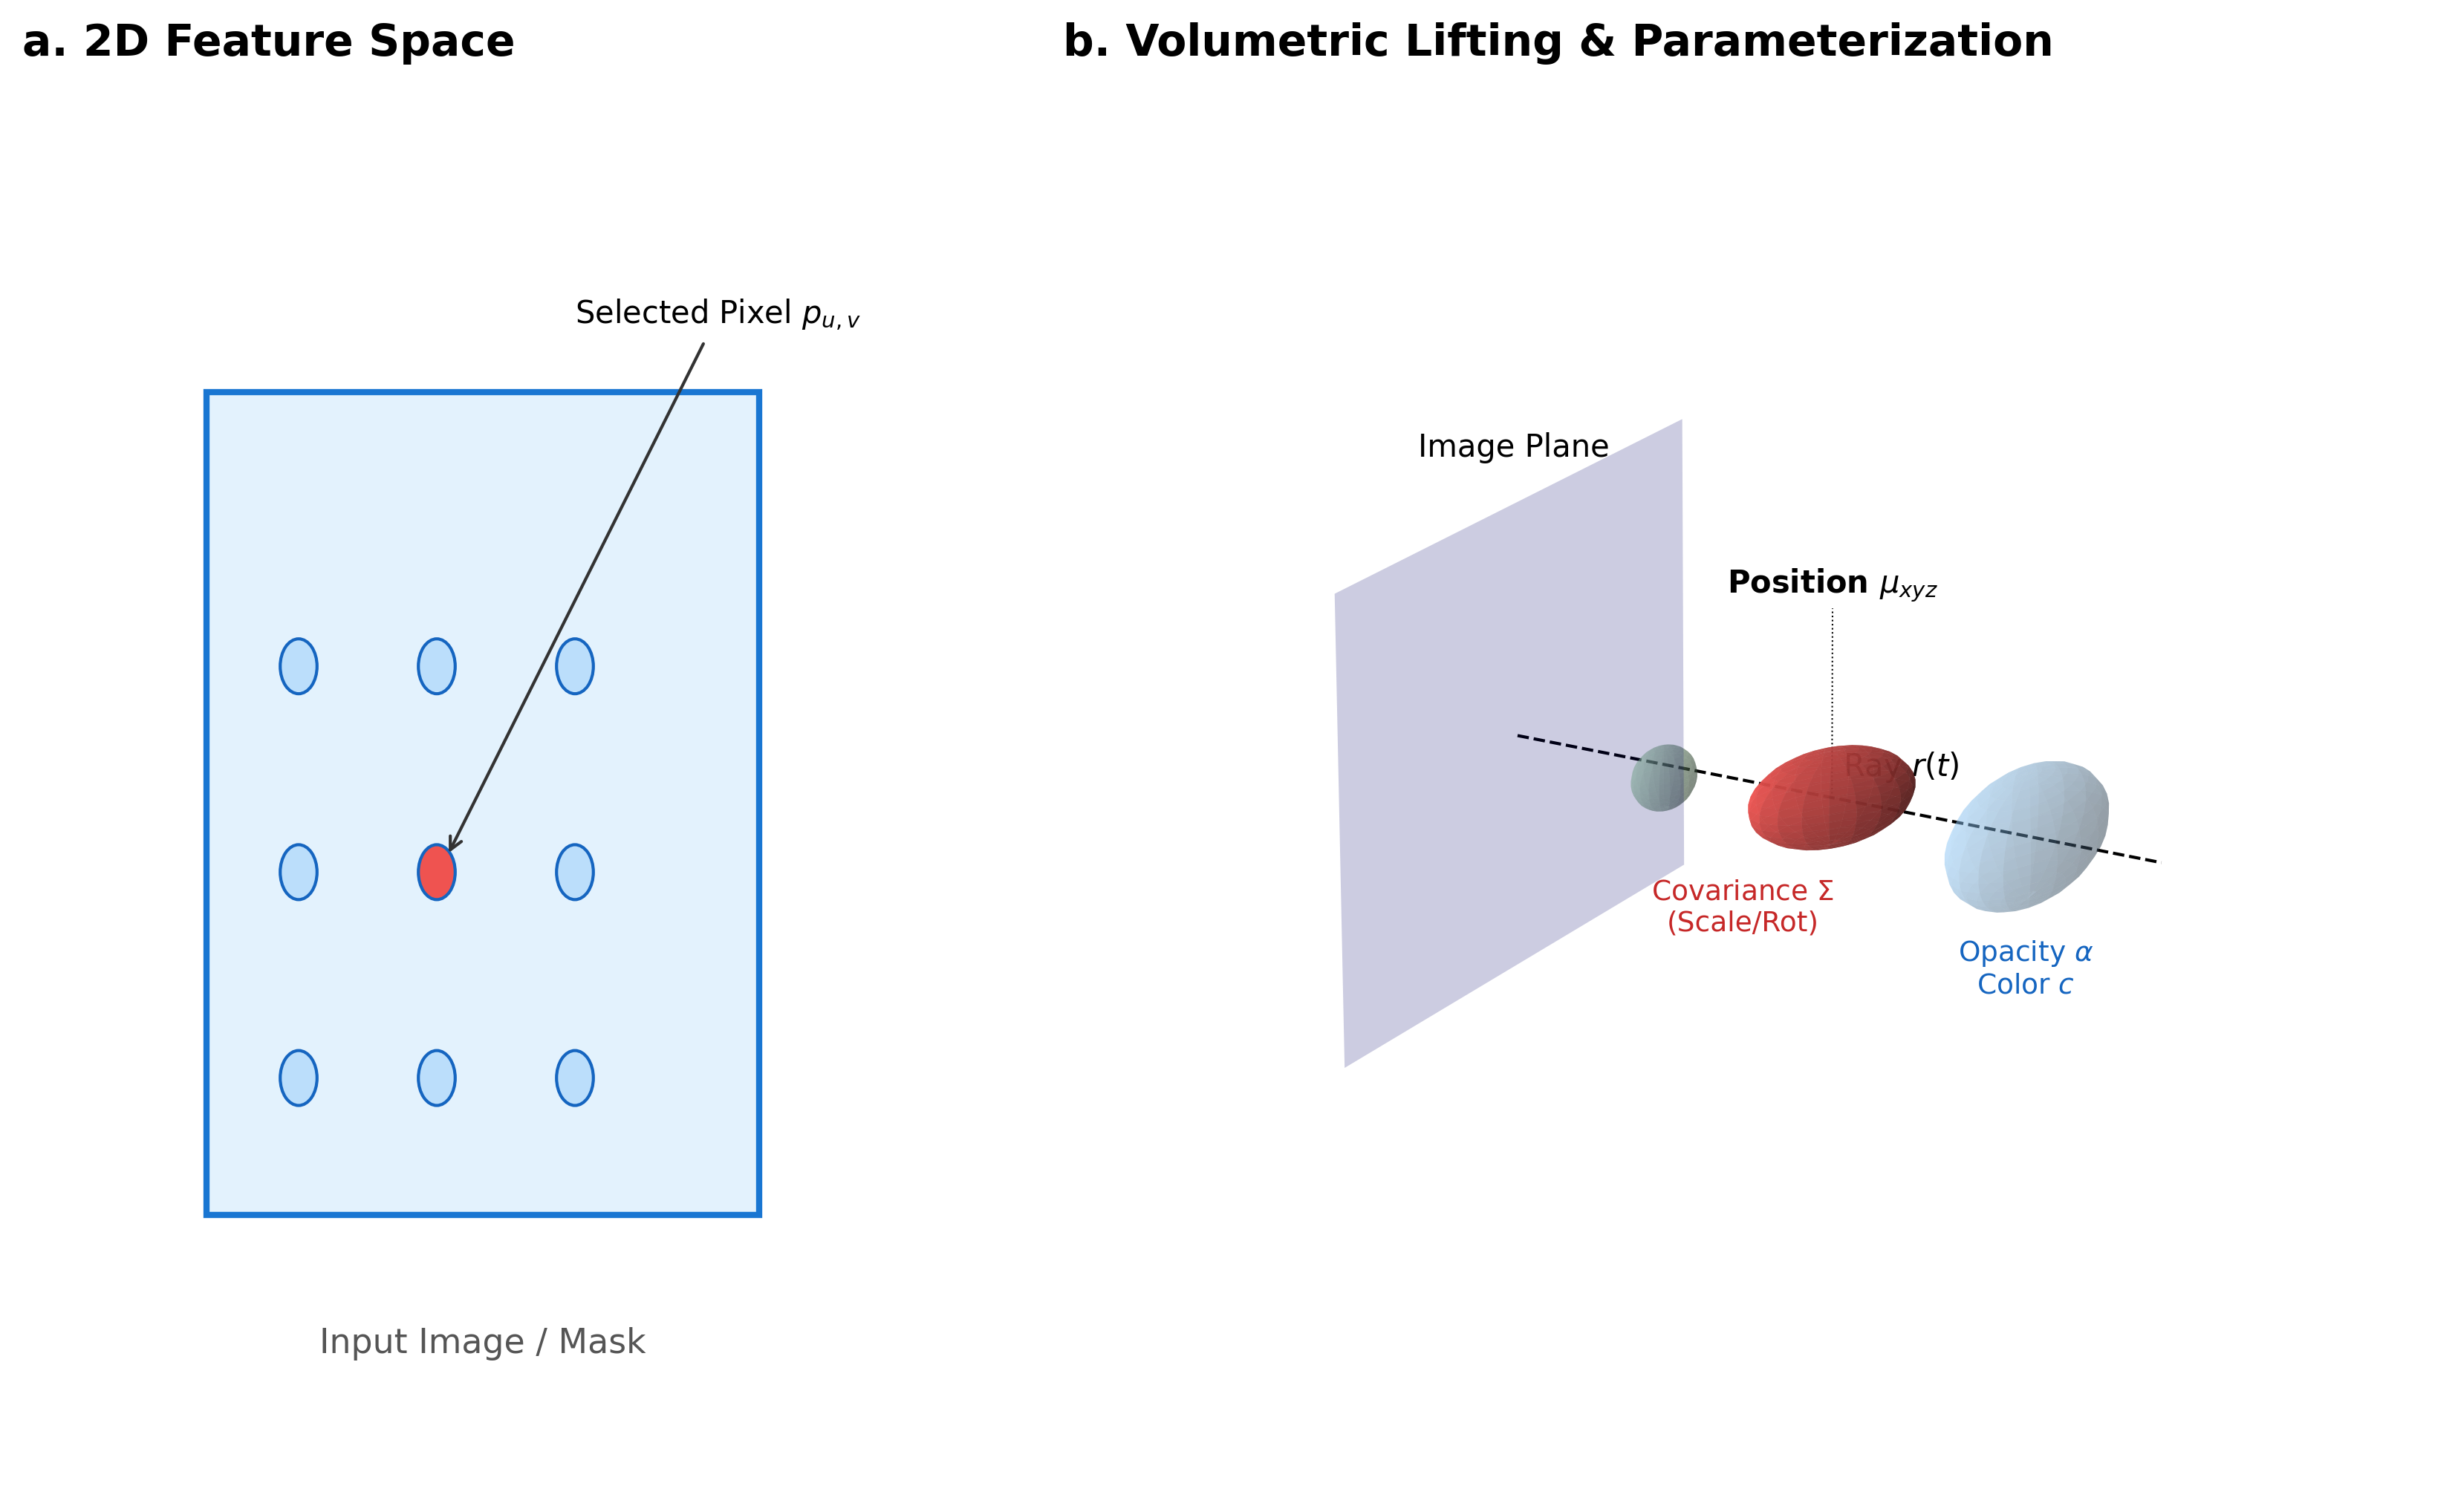

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch, Ellipse
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_3d_gaussian(ax, center, radii, rotation_deg=0, color='b', alpha=0.5):
    """
    Draws a 3D ellipsoid to represent a Gaussian splat.
    Simple wireframe or surface approximation.
    """
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    
    # Ellipsoid equation
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    # Rotation (Simple Z-axis rotation for visualization)
    theta = np.radians(rotation_deg)
    c, s = np.cos(theta), np.sin(theta)
    
    x_rot = x * c - y * s + center[0]
    y_rot = x * s + y * c + center[1]
    z_rot = z + center[2]

    ax.plot_surface(x_rot, y_rot, z_rot, color=color, alpha=alpha, shade=True, linewidth=0, antialiased=True)

def plot_lifting_illustration():
    # Setup Figure
    fig = plt.figure(figsize=(14, 8), dpi=300)
    fig.patch.set_facecolor('white')
    
    # Grid: Left (2D Input) -> Middle (Lifting) -> Right (3D Output)
    # We use a mixed 2D/3D layout
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5], wspace=0.1)

    # === PANEL A: 2D Feature Extraction ===
    ax_2d = fig.add_subplot(gs[0])
    ax_2d.set_title("a. 2D Feature Space", loc='left', fontsize=14, fontweight='bold', pad=20)
    ax_2d.axis('off')
    ax_2d.set_xlim(0, 100)
    ax_2d.set_ylim(0, 100)

    # Draw "Image Plane"
    rect_plane = patches.Rectangle((20, 20), 60, 60, facecolor='#E3F2FD', edgecolor='#1976D2', lw=2)
    ax_2d.add_patch(rect_plane)
    
    # Draw "Pixels" / Features
    for i in [30, 45, 60]:
        for j in [30, 45, 60]:
            c = '#EF5350' if i==45 and j==45 else '#BBDEFB'
            circle = patches.Circle((i, j), 2, facecolor=c, edgecolor='#1565C0')
            ax_2d.add_patch(circle)
            
    # Annotate the specific pixel
    ax_2d.annotate("Selected Pixel $p_{u,v}$", xy=(46, 46), xytext=(60, 85),
                   arrowprops=dict(arrowstyle="->", color="#333"), fontsize=10)
    
    ax_2d.text(50, 10, "Input Image / Mask", ha='center', fontsize=11, color='#555')

    # === PANEL B: 3D Lifting Process ===
    # This needs to be a 3D plot
    ax_3d = fig.add_subplot(gs[1], projection='3d')
    ax_3d.set_title("b. Volumetric Lifting & Parameterization", loc='left', fontsize=14, fontweight='bold', pad=20)
    
    # Hide standard axes
    ax_3d.set_axis_off()
    ax_3d.set_xlim(-1, 5)
    ax_3d.set_ylim(-2, 2)
    ax_3d.set_zlim(-2, 2)

    # 1. Draw Camera / Image Plane Origin
    # A simple plane in 3D
    y = np.linspace(-1.5, 1.5, 2)
    z = np.linspace(-1.5, 1.5, 2)
    Y, Z = np.meshgrid(y, z)
    X = np.zeros_like(Y) # Plane at x=0
    ax_3d.plot_surface(X, Y, Z, alpha=0.2, color='blue')
    ax_3d.text(0, 0, 1.8, "Image Plane", ha='center')

    # 2. Draw Viewing Frustum / Ray
    # Ray from origin (0,0,0) outwards
    ax_3d.plot([0, 5], [0, 0], [0, 0], color='black', linestyle='--', linewidth=1)
    ax_3d.text(2.5, 0.1, 0.1, "Ray $r(t)$", fontsize=10)

    # 3. Draw Gaussian Primitives along the ray
    # Gaussian 1 (Background/Far)
    draw_3d_gaussian(ax_3d, center=(4, 0, 0), radii=(0.4, 0.6, 0.4), rotation_deg=0, color='#90CAF9', alpha=0.3)
    
    # Gaussian 2 (The Object/Vessel - Matches the red pixel in Panel A)
    draw_3d_gaussian(ax_3d, center=(2.5, 0, 0), radii=(0.5, 0.3, 0.3), rotation_deg=45, color='#EF5350', alpha=0.8)
    
    # Gaussian 3 (Foreground/Noise)
    draw_3d_gaussian(ax_3d, center=(1, 0.2, -0.2), radii=(0.2, 0.2, 0.2), rotation_deg=0, color='#A5D6A7', alpha=0.4)

    # 4. Annotations for Gaussian Parameters
    # Position
    ax_3d.plot([2.5, 2.5], [0, 0], [0, 1.2], color='k', lw=0.5, linestyle=':')
    ax_3d.text(2.5, 0, 1.3, "Position $\mu_{xyz}$", ha='center', fontsize=10, fontweight='bold')
    
    # Covariance (Scale/Rot)
    ax_3d.text(2.5, -0.8, -0.5, "Covariance $\Sigma$\n(Scale/Rot)", ha='center', fontsize=9, color='#C62828')
    
    # Opacity/Color
    ax_3d.text(4, 0, -1, "Opacity $\\alpha$\nColor $c$", ha='center', fontsize=9, color='#1565C0')

    # View Angle
    ax_3d.view_init(elev=20, azim=-60)

    # Connect Panel A to B (Schematic arrow drawn on figure coords)
    # This is tricky in matplotlib mixed 2D/3D, using arbitrary coordinates for visual flow
    
    plt.tight_layout()
    plt.savefig('gaussian_lifting_nature_style.svg', format='svg')
    print("Illustration saved to 'gaussian_lifting_nature_style.svg'")

plot_lifting_illustration()

/tmp/ipykernel_1110327/2660519693.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.12, 1, 1])


Illustration saved to 'gaussian_lifting_nature_style.svg'


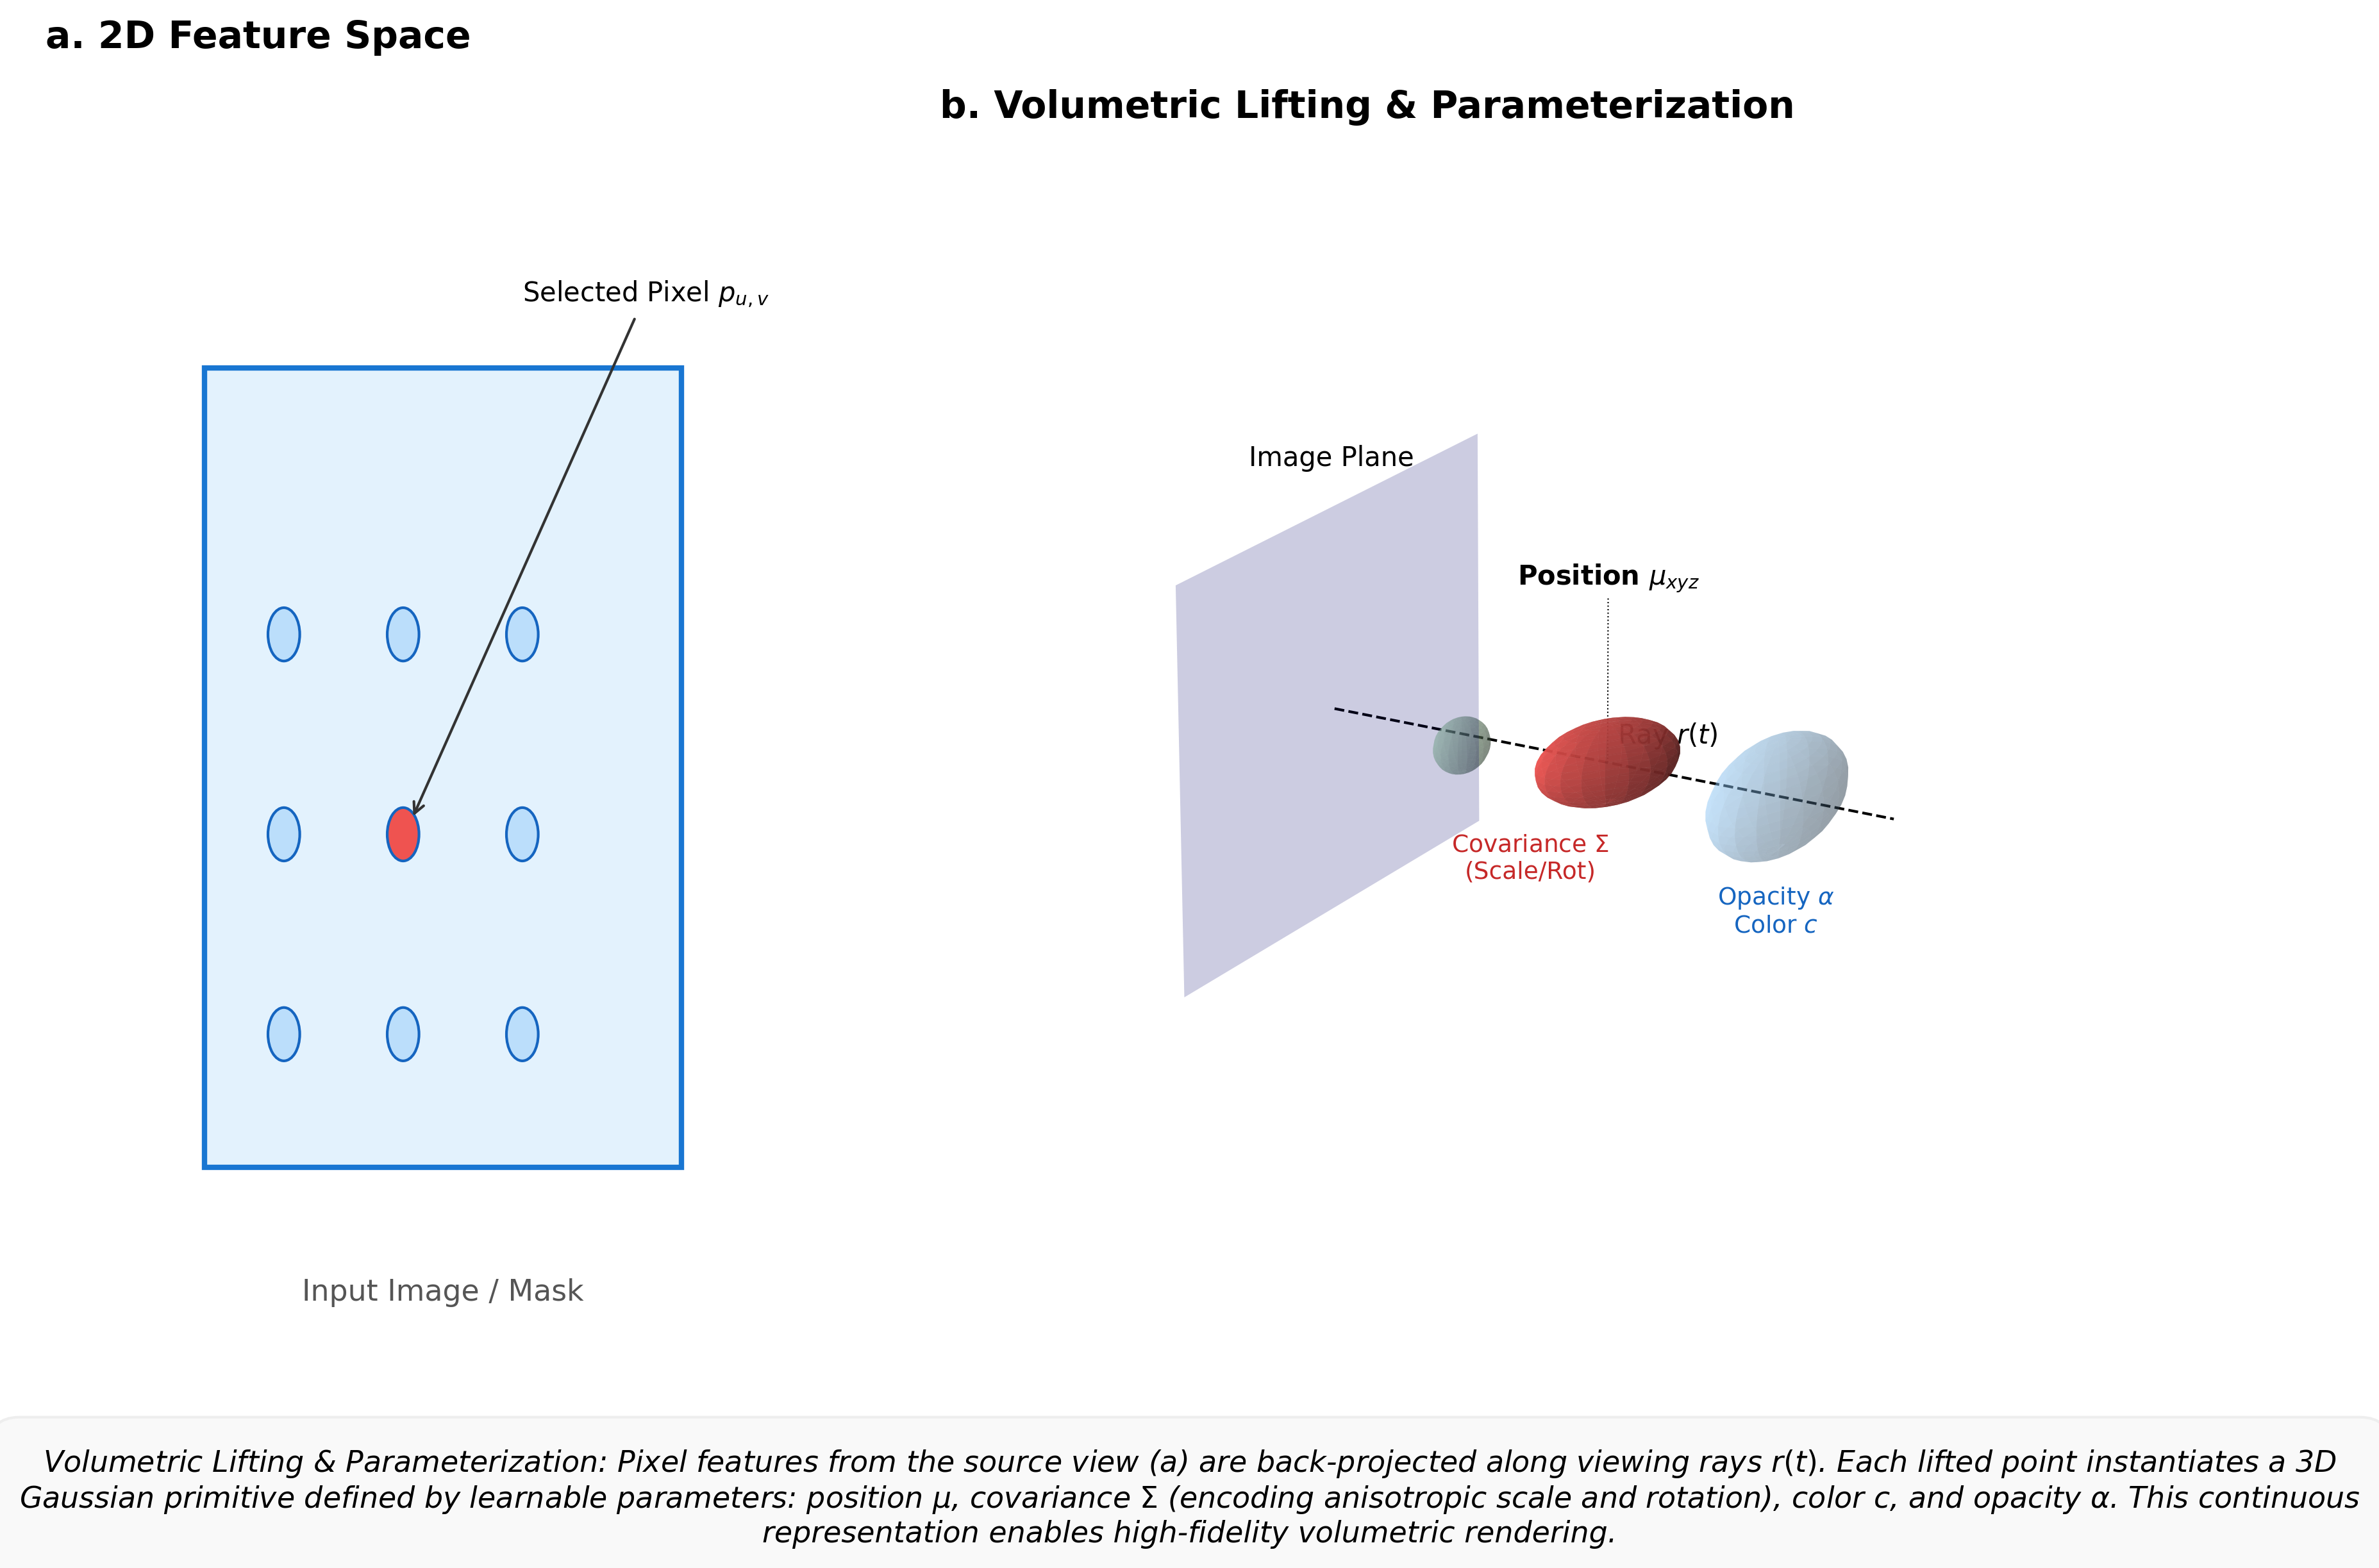

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import FancyArrowPatch, Ellipse
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def draw_3d_gaussian(ax, center, radii, rotation_deg=0, color='b', alpha=0.5):
    """
    Draws a 3D ellipsoid to represent a Gaussian splat.
    Simple wireframe or surface approximation.
    """
    u = np.linspace(0, 2 * np.pi, 20)
    v = np.linspace(0, np.pi, 20)
    
    # Ellipsoid equation
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))

    # Rotation (Simple Z-axis rotation for visualization)
    theta = np.radians(rotation_deg)
    c, s = np.cos(theta), np.sin(theta)
    
    x_rot = x * c - y * s + center[0]
    y_rot = x * s + y * c + center[1]
    z_rot = z + center[2]

    ax.plot_surface(x_rot, y_rot, z_rot, color=color, alpha=alpha, shade=True, linewidth=0, antialiased=True)

def plot_lifting_illustration():
    # Setup Figure
    fig = plt.figure(figsize=(14, 9), dpi=300)
    fig.patch.set_facecolor('white')
    
    # Grid: Left (2D Input) -> Middle (Lifting) -> Right (3D Output)
    # We use a mixed 2D/3D layout
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.5], wspace=0.1)

    # === PANEL A: 2D Feature Extraction ===
    ax_2d = fig.add_subplot(gs[0])
    ax_2d.set_title("a. 2D Feature Space", loc='left', fontsize=14, fontweight='bold', pad=20)
    ax_2d.axis('off')
    ax_2d.set_xlim(0, 100)
    ax_2d.set_ylim(0, 100)

    # Draw "Image Plane"
    rect_plane = patches.Rectangle((20, 20), 60, 60, facecolor='#E3F2FD', edgecolor='#1976D2', lw=2)
    ax_2d.add_patch(rect_plane)
    
    # Draw "Pixels" / Features
    for i in [30, 45, 60]:
        for j in [30, 45, 60]:
            c = '#EF5350' if i==45 and j==45 else '#BBDEFB'
            circle = patches.Circle((i, j), 2, facecolor=c, edgecolor='#1565C0')
            ax_2d.add_patch(circle)
            
    # Annotate the specific pixel
    ax_2d.annotate("Selected Pixel $p_{u,v}$", xy=(46, 46), xytext=(60, 85),
                   arrowprops=dict(arrowstyle="->", color="#333"), fontsize=10)
    
    ax_2d.text(50, 10, "Input Image / Mask", ha='center', fontsize=11, color='#555')

    # === PANEL B: 3D Lifting Process ===
    # This needs to be a 3D plot
    ax_3d = fig.add_subplot(gs[1], projection='3d')
    ax_3d.set_title("b. Volumetric Lifting & Parameterization", loc='left', fontsize=14, fontweight='bold', pad=20)
    
    # Hide standard axes
    ax_3d.set_axis_off()
    ax_3d.set_xlim(-1, 5)
    ax_3d.set_ylim(-2, 2)
    ax_3d.set_zlim(-2, 2)

    # 1. Draw Camera / Image Plane Origin
    # A simple plane in 3D
    y = np.linspace(-1.5, 1.5, 2)
    z = np.linspace(-1.5, 1.5, 2)
    Y, Z = np.meshgrid(y, z)
    X = np.zeros_like(Y) # Plane at x=0
    ax_3d.plot_surface(X, Y, Z, alpha=0.2, color='blue')
    ax_3d.text(0, 0, 1.8, "Image Plane", ha='center')

    # 2. Draw Viewing Frustum / Ray
    # Ray from origin (0,0,0) outwards
    ax_3d.plot([0, 5], [0, 0], [0, 0], color='black', linestyle='--', linewidth=1)
    ax_3d.text(2.5, 0.1, 0.1, "Ray $r(t)$", fontsize=10)

    # 3. Draw Gaussian Primitives along the ray
    # Gaussian 1 (Background/Far)
    draw_3d_gaussian(ax_3d, center=(4, 0, 0), radii=(0.4, 0.6, 0.4), rotation_deg=0, color='#90CAF9', alpha=0.3)
    
    # Gaussian 2 (The Object/Vessel - Matches the red pixel in Panel A)
    draw_3d_gaussian(ax_3d, center=(2.5, 0, 0), radii=(0.5, 0.3, 0.3), rotation_deg=45, color='#EF5350', alpha=0.8)
    
    # Gaussian 3 (Foreground/Noise)
    draw_3d_gaussian(ax_3d, center=(1, 0.2, -0.2), radii=(0.2, 0.2, 0.2), rotation_deg=0, color='#A5D6A7', alpha=0.4)

    # 4. Annotations for Gaussian Parameters
    # Position
    ax_3d.plot([2.5, 2.5], [0, 0], [0, 1.2], color='k', lw=0.5, linestyle=':')
    ax_3d.text(2.5, 0, 1.3, "Position $\mu_{xyz}$", ha='center', fontsize=10, fontweight='bold')
    
    # Covariance (Scale/Rot)
    ax_3d.text(2.5, -0.8, -0.5, "Covariance $\Sigma$\n(Scale/Rot)", ha='center', fontsize=9, color='#C62828')
    
    # Opacity/Color
    ax_3d.text(4, 0, -1, "Opacity $\\alpha$\nColor $c$", ha='center', fontsize=9, color='#1565C0')

    # View Angle
    ax_3d.view_init(elev=20, azim=-60)

    # Connect Panel A to B (Schematic arrow drawn on figure coords)
    # This is tricky in matplotlib mixed 2D/3D, using arbitrary coordinates for visual flow
    
    # Add Caption for Section B
    caption_text = (
        "Volumetric Lifting & Parameterization: Pixel features from the source view (a) are back-projected along viewing rays $r(t)$. "
        "Each lifted point instantiates a 3D Gaussian primitive defined by learnable parameters: position $\mu$, covariance $\Sigma$ (encoding anisotropic scale and rotation), "
        "color $c$, and opacity $\\alpha$. This continuous representation enables high-fidelity volumetric rendering."
    )
    # Place caption at the bottom of the figure, spanning mostly the 3D section
    fig.text(0.55, 0.05, caption_text, ha='center', fontsize=11, style='italic', wrap=True, bbox=dict(boxstyle="round,pad=1", fc="#f9f9f9", ec="#eee"))

    plt.tight_layout(rect=[0, 0.12, 1, 1])
    plt.savefig('gaussian_lifting_nature_style.svg', format='svg')
    print("Illustration saved to 'gaussian_lifting_nature_style.svg'")

plot_lifting_illustration()

/tmp/ipykernel_1110327/1561841388.py:171: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 1, 1])


Illustration saved to 'gaussian_lifting_nature_style.svg'


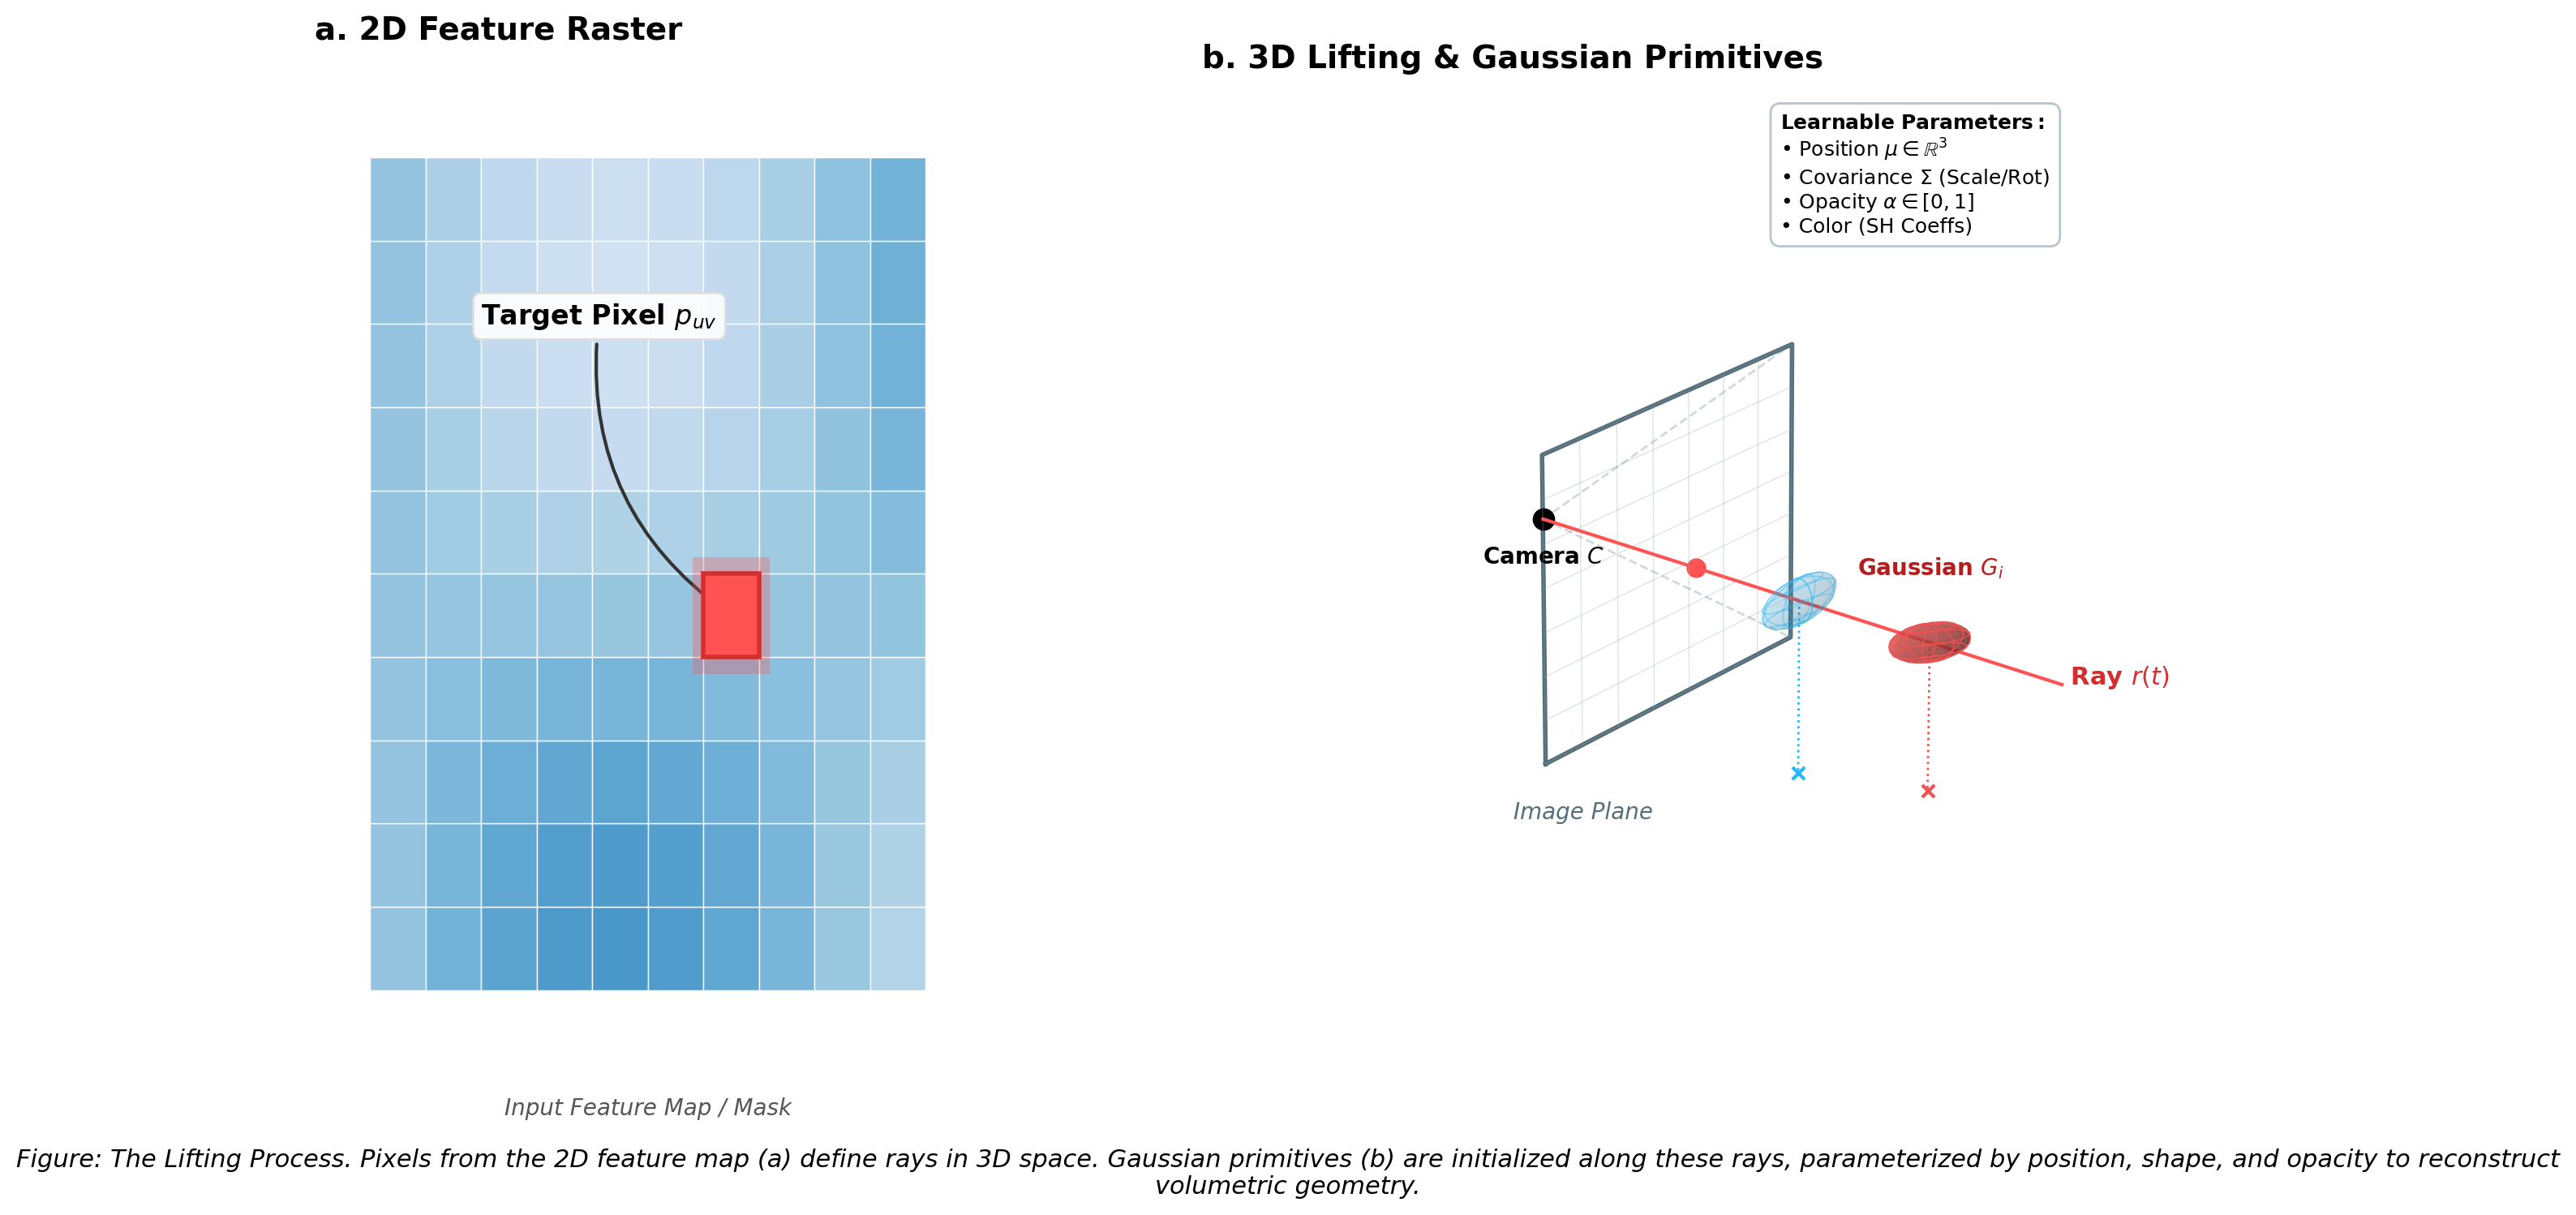

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def draw_3d_ellipsoid(ax, center, radii, rotation_matrix, color, alpha=0.3):
    """
    Draws a 3D ellipsoid with rotation, surface, and wireframe for a technical look.
    """
    # Create sphere mesh
    u = np.linspace(0, 2 * np.pi, 25)
    v = np.linspace(0, np.pi, 15)
    
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Rotate and translate
    # Stack coordinates for vectorized rotation
    points = np.stack([x.flatten(), y.flatten(), z.flatten()])
    rot_points = rotation_matrix @ points
    
    x_rot = rot_points[0, :].reshape(x.shape) + center[0]
    y_rot = rot_points[1, :].reshape(y.shape) + center[1]
    z_rot = rot_points[2, :].reshape(z.shape) + center[2]
    
    # Plot Surface (Skin)
    ax.plot_surface(x_rot, y_rot, z_rot, color=color, alpha=alpha, 
                    rstride=1, cstride=1, linewidth=0, antialiased=True, shade=True)
    
    # Plot Wireframe (Structure)
    ax.plot_wireframe(x_rot, y_rot, z_rot, color=color, alpha=alpha+0.3, 
                      rstride=3, cstride=3, linewidth=0.5)

def plot_lifting_illustration():
    fig = plt.figure(figsize=(16, 8), dpi=200)
    fig.patch.set_facecolor('white')
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.8, 1.5], wspace=0.1)
    
    # === PANEL A: 2D PIXEL GRID ===
    ax2d = fig.add_subplot(gs[0])
    ax2d.set_title("a. 2D Feature Raster", loc='left', fontsize=14, fontweight='bold', pad=15)
    ax2d.axis('off')
    ax2d.set_xlim(-1, 11)
    ax2d.set_ylim(-1, 11)
    
    # Draw Pixel Grid with a "Heatmap" style look
    grid_size = 10
    for x in range(grid_size):
        for y in range(grid_size):
            # Create a mock "structure" using sine waves
            val = np.sin(x*0.4) * np.cos(y*0.4)
            # Use a medical/biological looking colormap (Blues)
            color = plt.cm.Blues(0.2 + 0.4 * (val + 1)/2)
            
            # Highlight specific pixel (the one we lift)
            if x == 6 and y == 4:
                # Highlight Color
                rect = patches.Rectangle((x, y), 1, 1, linewidth=2, edgecolor='#D32F2F', facecolor='#FF5252', zorder=10)
                # Glow effect ring
                glow = patches.Rectangle((x-0.2, y-0.2), 1.4, 1.4, linewidth=0, facecolor='#FF5252', alpha=0.3, zorder=5)
                ax2d.add_patch(glow)
            else:
                rect = patches.Rectangle((x, y), 1, 1, linewidth=0.5, edgecolor='white', facecolor=color)
                
            ax2d.add_patch(rect)

    # Annotations Panel A
    ax2d.annotate("Target Pixel $p_{uv}$", xy=(6.5, 4.5), xytext=(2, 8),
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color="#333", lw=1.5),
                  fontsize=12, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#ddd", alpha=0.9))
    
    ax2d.text(5, -1.5, "Input Feature Map / Mask", ha='center', color='#555', fontsize=10, style='italic')

    # === PANEL B: 3D VOLUMETRIC LIFTING ===
    ax3d = fig.add_subplot(gs[1], projection='3d')
    ax3d.set_title("b. 3D Lifting & Gaussian Primitives", loc='left', fontsize=14, fontweight='bold', pad=0)
    
    # Setup Scene limits
    ax3d.set_xlim(-2, 10)
    ax3d.set_ylim(-3, 3)
    ax3d.set_zlim(-3, 3)
    ax3d.set_axis_off()
    
    # 1. Camera Center (Origin)
    ax3d.scatter([0], [0], [0], color='black', s=80, label='Camera Center', zorder=100)
    ax3d.text(0, 0, -0.6, "Camera $C$", ha='center', fontsize=10, fontweight='bold')
    
    # 2. Image Plane & Frustum
    plane_x = 3
    
    # Draw Frustum Lines (Cone of vision)
    frustum_color = '#CFD8DC'
    for y in [-2, 2]:
        for z in [-2, 2]:
            ax3d.plot([0, plane_x], [0, y], [0, z], color=frustum_color, linestyle='--', linewidth=1)
            
    # Draw Image Plane Grid (Wireframe)
    Y, Z = np.meshgrid(np.linspace(-2, 2, 8), np.linspace(-2, 2, 8))
    X = np.full_like(Y, plane_x)
    ax3d.plot_wireframe(X, Y, Z, color='#90A4AE', alpha=0.3, linewidth=0.5)
    # Thick Border for Image Plane
    ax3d.plot([plane_x]*5, [-2, 2, 2, -2, -2], [-2, -2, 2, 2, -2], color='#546E7A', linewidth=2)
    ax3d.text(plane_x, -2.5, -2.5, "Image Plane", color='#546E7A', fontsize=10, style='italic')
    
    # 3. Ray Casting
    # Determine ray direction based on the "selected pixel" from Panel A
    # Mapping [0..10] grid to [-2..2] plane
    # x=6 -> 6/10 * 4 - 2 = 0.4
    # y=4 -> 4/10 * 4 - 2 = -0.4
    # Note: in 3D plot, Y is horizontal, Z is vertical
    pixel_y, pixel_z = 0.4, -0.4 
    
    # Highlight pixel on 3D plane
    ax3d.scatter([plane_x], [pixel_y], [pixel_z], color='#FF5252', s=60, zorder=10)
    
    # Draw the Viewing Ray
    ray_len = 10
    ray_end_y = pixel_y * (ray_len/plane_x)
    ray_end_z = pixel_z * (ray_len/plane_x)
    
    ax3d.plot([0, ray_len], [0, ray_end_y], [0, ray_end_z], color='#FF5252', linewidth=1.5, zorder=5)
    ax3d.text(ray_len, ray_end_y, ray_end_z, " Ray $r(t)$", color='#D32F2F', fontsize=11, fontweight='bold')
    
    # 4. Gaussians along the ray
    # Gaussian 1 (Closer, context/noise)
    pos1 = np.array([5.0, pixel_y*(5/plane_x), pixel_z*(5/plane_x)])
    rot1 = np.eye(3) 
    draw_3d_ellipsoid(ax3d, pos1, [0.3, 0.6, 0.3], rot1, '#29B6F6', alpha=0.15)
    
    # Gaussian 2 (The Main Feature - Rotated)
    pos2 = np.array([7.5, pixel_y*(7.5/plane_x), pixel_z*(7.5/plane_x)])
    # Rotation Matrix (Rotate around Z)
    theta = np.radians(30)
    c, s = np.cos(theta), np.sin(theta)
    rot2 = np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]]) 
    draw_3d_ellipsoid(ax3d, pos2, [0.6, 0.25, 0.25], rot2, '#EF5350', alpha=0.6)
    
    # 5. Depth Cues (Drop lines to floor)
    floor_z = -3
    for pos, col in [(pos1, '#29B6F6'), (pos2, '#EF5350')]:
        # Dashed line from center to floor
        ax3d.plot([pos[0], pos[0]], [pos[1], pos[1]], [pos[2], floor_z], color=col, linestyle=':', linewidth=1)
        # 'X' mark on floor
        ax3d.scatter([pos[0]], [pos[1]], [floor_z], color=col, marker='x', s=30)

    # 6. Parameter Annotations
    ax3d.text(pos2[0], pos2[1], pos2[2]+0.9, "Gaussian $G_i$", ha='center', color='#B71C1C', fontweight='bold')
    
    # Parameter Legend Box
    param_text = (
        "$\mathbf{Learnable\ Parameters:}$\n"
        "• Position $\mu \in \mathbb{R}^3$\n"
        "• Covariance $\Sigma$ (Scale/Rot)\n"
        "• Opacity $\\alpha \in [0,1]$\n"
        "• Color (SH Coeffs)"
    )
    # Place legend in empty space
    ax3d.text(0, 4, 2.5, param_text, fontsize=9, 
              bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#B0BEC5", alpha=0.9))

    # View angle
    ax3d.view_init(elev=20, azim=-55)
    
    # Global caption
    caption = "Figure: The Lifting Process. Pixels from the 2D feature map (a) define rays in 3D space. Gaussian primitives (b) are initialized along these rays, parameterized by position, shape, and opacity to reconstruct volumetric geometry."
    fig.text(0.5, 0.02, caption, ha='center', fontsize=11, style='italic', wrap=True)

    plt.tight_layout(rect=[0, 0.05, 1, 1])
    plt.savefig('gaussian_lifting_nature_style.svg', format='svg')
    print("Illustration saved to 'gaussian_lifting_nature_style.svg'")

plot_lifting_illustration()

/tmp/ipykernel_1110327/1818262729.py:161: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


Illustration saved to 'gaussian_primitives_nature_style.svg'


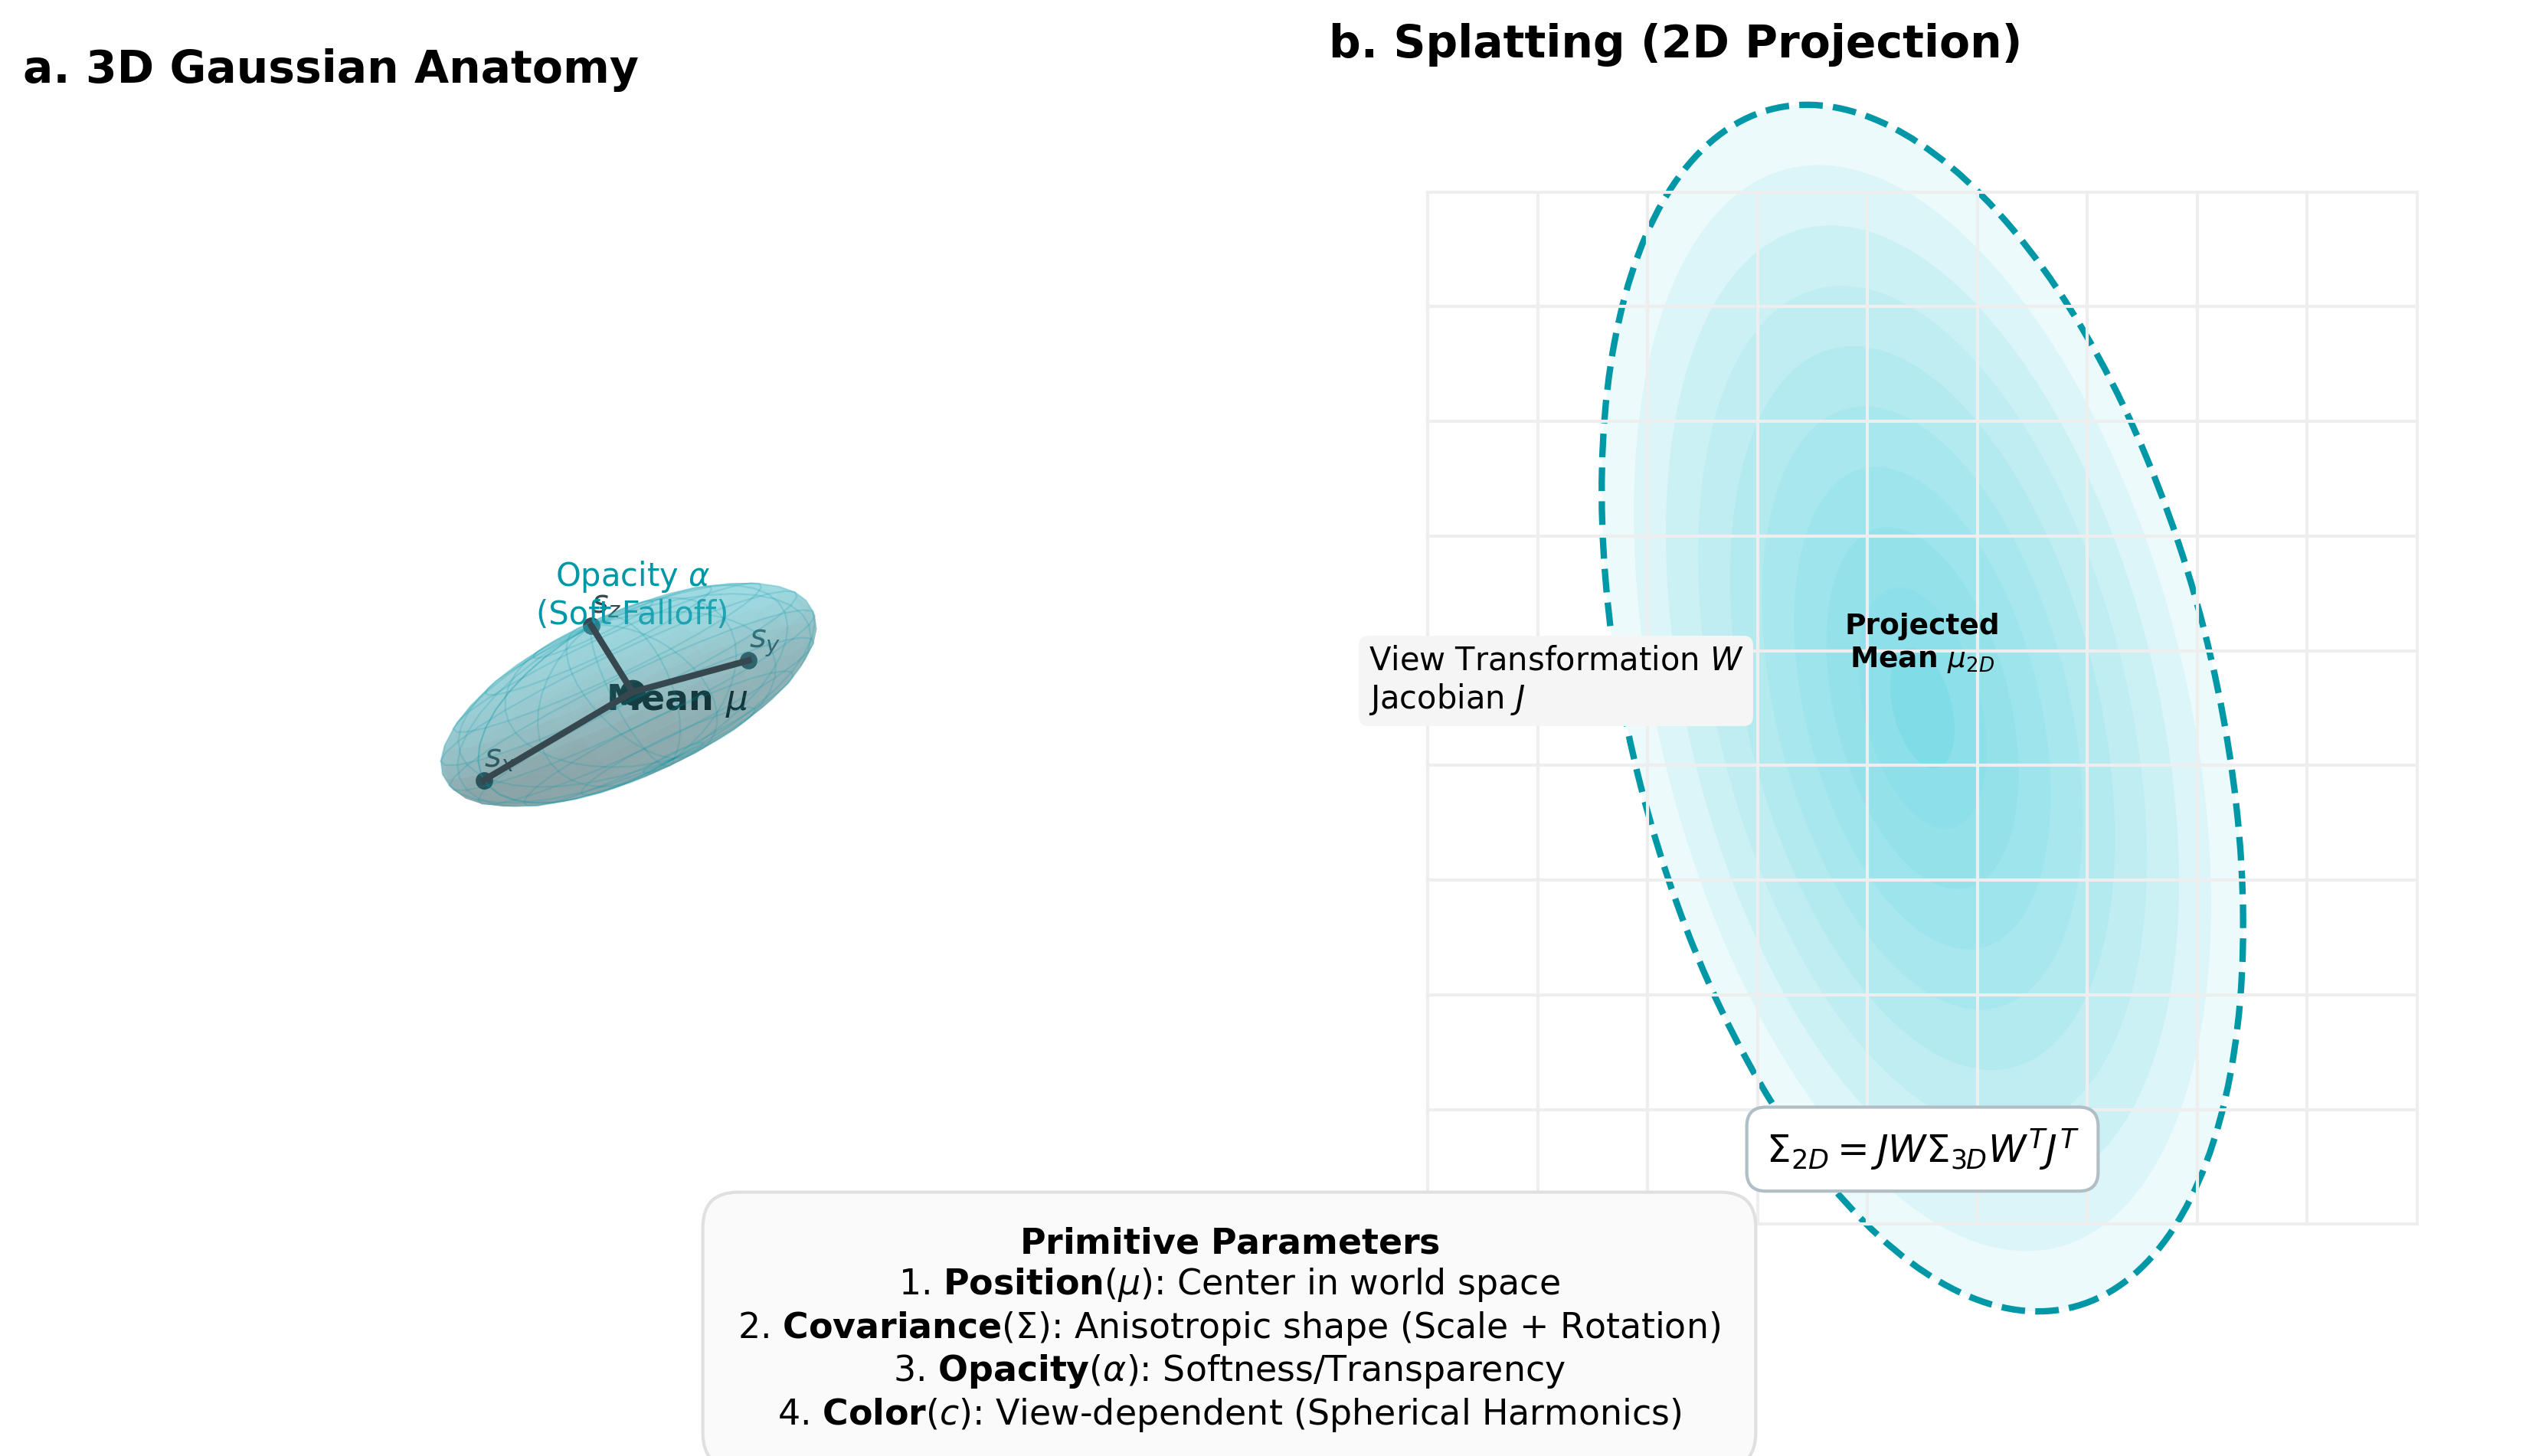

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def draw_eigen_vectors(ax, center, eig_vecs, eig_vals, color='black'):
    """Draws the principal axes of the Gaussian."""
    for i in range(3):
        # Scale vector by eigenvalue (radius)
        vec = eig_vecs[:, i] * eig_vals[i]
        start = center
        end = center + vec
        
        # Draw arrow
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
                color=color, lw=2, zorder=100)
        # Add tip (simple scatter for 3d arrow tip)
        ax.scatter([end[0]], [end[1]], [end[2]], color=color, s=20)
        
        # Label axes
        label = ["$s_x$", "$s_y$", "$s_z$"][i]
        ax.text(end[0], end[1], end[2]+0.1, label, fontsize=10, fontweight='bold', color=color)

def plot_primitives_illustration():
    fig = plt.figure(figsize=(14, 7), dpi=300)
    fig.patch.set_facecolor('white')
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    
    # ==========================================
    # PANEL A: 3D ANATOMY (Geometry & Properties)
    # ==========================================
    ax3d = fig.add_subplot(gs[0], projection='3d')
    ax3d.set_title("a. 3D Gaussian Anatomy", loc='left', fontsize=14, fontweight='bold', pad=10)
    ax3d.set_axis_off()
    ax3d.set_xlim(-2, 2)
    ax3d.set_ylim(-2, 2)
    ax3d.set_zlim(-2, 2)
    
    # 1. Define Gaussian Parameters
    center = np.array([0, 0, 0])
    radii = np.array([1.5, 0.8, 0.5]) # Scale
    
    # Rotation (Quaternion/Matrix)
    theta = np.radians(30)
    phi = np.radians(15)
    # Simple rotation matrix construction
    Rx = np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    Rz = np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
    R = Rz @ Rx
    
    # 2. Draw Ellipsoid Surface
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Rotate
    points = np.stack([x.flatten(), y.flatten(), z.flatten()])
    rot_points = R @ points
    x_rot = rot_points[0, :].reshape(x.shape) + center[0]
    y_rot = rot_points[1, :].reshape(y.shape) + center[1]
    z_rot = rot_points[2, :].reshape(z.shape) + center[2]
    
    # Plot semi-transparent skin
    surf = ax3d.plot_surface(x_rot, y_rot, z_rot, color='#4DD0E1', alpha=0.3, 
                            rstride=1, cstride=1, linewidth=0, shade=True)
    # Plot wireframe
    ax3d.plot_wireframe(x_rot, y_rot, z_rot, color='#0097A7', alpha=0.2, 
                        rstride=2, cstride=2, linewidth=0.5)

    # 3. Draw Principal Axes (Eigenvectors of Covariance)
    # The columns of R are the eigenvectors, radii are eigenvalues (sqrt)
    draw_eigen_vectors(ax3d, center, R, radii, color='#37474F')

    # 4. Annotations
    ax3d.scatter([0], [0], [0], color='black', s=50, label='Mean')
    ax3d.text(0, -0.2, -0.2, "Mean $\mu$", fontsize=11, fontweight='bold')
    
    # Visualizing Opacity (Gradient Sphere Logic - schematic)
    ax3d.text(1.5, 1.5, 1.5, "Opacity $\\alpha$\n(Soft Falloff)", fontsize=10, color='#0097A7', ha='center')
    
    ax3d.view_init(elev=20, azim=45)

    # ==========================================
    # PANEL B: SPLATTING (Projection to 2D)
    # ==========================================
    ax2d = fig.add_subplot(gs[1])
    ax2d.set_title("b. Splatting (2D Projection)", loc='left', fontsize=14, fontweight='bold', pad=10)
    ax2d.axis('off')
    ax2d.set_xlim(-3, 3)
    ax2d.set_ylim(-3, 3)
    
    # 1. Draw Image Plane Grid
    grid_x = np.linspace(-2.5, 2.5, 10)
    grid_y = np.linspace(-2.5, 2.5, 10)
    for gx in grid_x:
        ax2d.plot([gx, gx], [-2.5, 2.5], color='#EEEEEE', linewidth=1)
    for gy in grid_y:
        ax2d.plot([-2.5, 2.5], [gy, gy], color='#EEEEEE', linewidth=1)

    # 2. Calculate 2D Projection (Approximation for visualization)
    # We take the top-left 2x2 of the rotated 3D covariance
    # Cov = R * S^2 * R.T
    S_mat = np.diag(radii**2)
    Cov_3d = R @ S_mat @ R.T
    
    # Project to 2D (Just taking XY slice for simplicity of diagram)
    Cov_2d = Cov_3d[0:2, 0:2]
    
    # Calculate 2D Eigenvalues/vectors for plotting ellipse
    vals_2d, vecs_2d = np.linalg.eigh(Cov_2d)
    angle_2d = np.degrees(np.arctan2(vecs_2d[1, 0], vecs_2d[0, 0]))
    width_2d, height_2d = 2 * np.sqrt(vals_2d) * 2 # 2 sigma confidence
    
    # 3. Draw The 2D Splat
    # Gradient filled ellipse (simulating Gaussian distribution)
    for scale in np.linspace(1.0, 0.1, 10):
        # Nested ellipses to create gradient look
        opacity = 0.1 if scale > 0.1 else 0.2
        ell = patches.Ellipse((0, 0), width_2d * scale, height_2d * scale, 
                              angle=angle_2d + 90, # Matplotlib rotation fix
                              facecolor='#4DD0E1', edgecolor='none', alpha=opacity)
        ax2d.add_patch(ell)
    
    # Outline
    ell_outline = patches.Ellipse((0, 0), width_2d, height_2d, 
                                  angle=angle_2d + 90, 
                                  facecolor='none', edgecolor='#0097A7', linewidth=2, linestyle='--')
    ax2d.add_patch(ell_outline)

    # 4. Mathematical Context
    # Connect Panel A to B concept
    ax2d.annotate("View Transformation $W$\nJacobian $J$", xy=(-1.5, 0), xytext=(-2.8, 0),
                 arrowprops=dict(arrowstyle="->", color="#555", lw=2),
                 fontsize=10, bbox=dict(boxstyle="round", fc="#F5F5F5", ec="none"))

    # Formula
    formula = r"$\Sigma_{2D} = J W \Sigma_{3D} W^T J^T$"
    ax2d.text(0, -2.2, formula, fontsize=12, ha='center', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#B0BEC5", lw=1))
             
    # Labels
    ax2d.text(0, 0.2, "Projected\nMean $\mu_{2D}$", ha='center', fontsize=9, fontweight='bold')
    
    # Legend for Parameters
    legend_text = (
        "$\mathbf{Primitive\ Parameters}$\n"
        "1. $\mathbf{Position} (\mu)$: Center in world space\n"
        "2. $\mathbf{Covariance} (\Sigma)$: Anisotropic shape (Scale + Rotation)\n"
        "3. $\mathbf{Opacity} (\\alpha)$: Softness/Transparency\n"
        "4. $\mathbf{Color} (c)$: View-dependent (Spherical Harmonics)"
    )
    
    # Place Legend in center bottom
    plt.figtext(0.5, 0.05, legend_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle="round,pad=1", fc="#FAFAFA", ec="#E0E0E0"))

    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.savefig('gaussian_primitives_nature_style.svg', format='svg')
    print("Illustration saved to 'gaussian_primitives_nature_style.svg'")

plot_primitives_illustration()

/tmp/ipykernel_1110327/3101295609.py:176: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])


Illustration saved to 'gaussian_primitives_nature_style.svg'


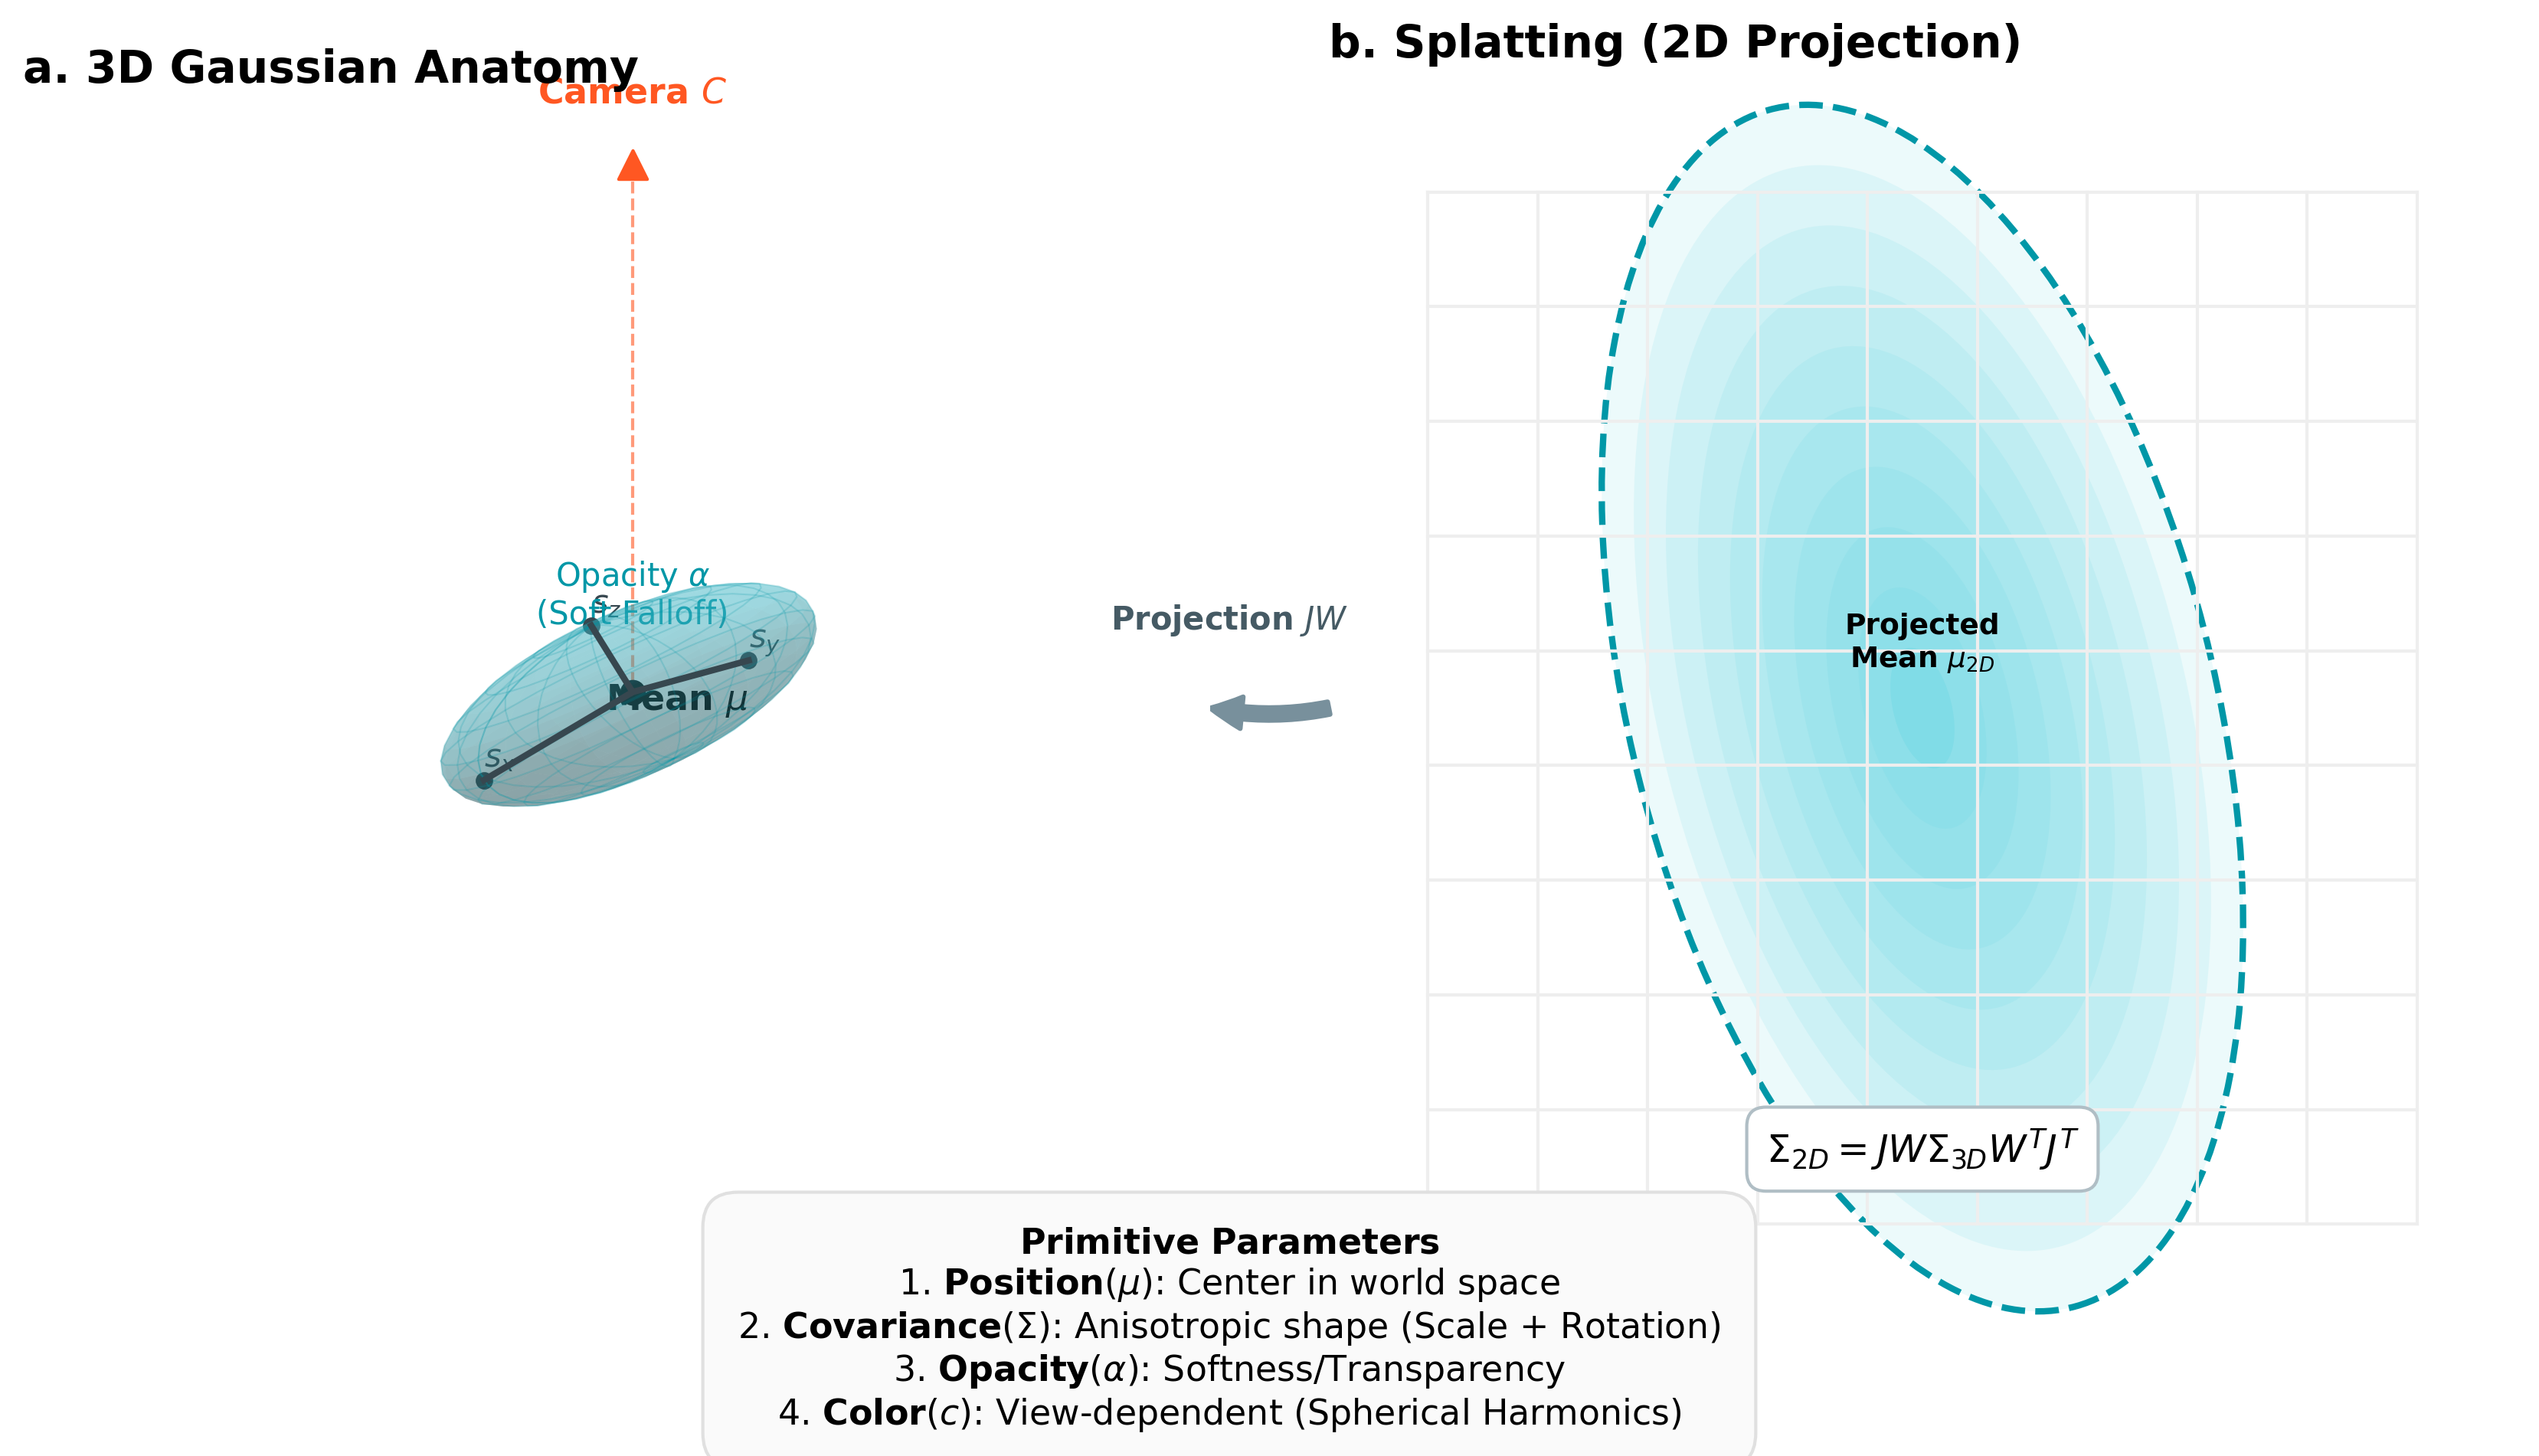

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

def draw_eigen_vectors(ax, center, eig_vecs, eig_vals, color='black'):
    """Draws the principal axes of the Gaussian."""
    for i in range(3):
        # Scale vector by eigenvalue (radius)
        vec = eig_vecs[:, i] * eig_vals[i]
        start = center
        end = center + vec
        
        # Draw arrow
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], 
                color=color, lw=2, zorder=100)
        # Add tip (simple scatter for 3d arrow tip)
        ax.scatter([end[0]], [end[1]], [end[2]], color=color, s=20)
        
        # Label axes
        label = ["$s_x$", "$s_y$", "$s_z$"][i]
        ax.text(end[0], end[1], end[2]+0.1, label, fontsize=10, fontweight='bold', color=color)

def plot_primitives_illustration():
    fig = plt.figure(figsize=(14, 7), dpi=300)
    fig.patch.set_facecolor('white')
    
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0.1)
    
    # ==========================================
    # PANEL A: 3D ANATOMY (Geometry & Properties)
    # ==========================================
    ax3d = fig.add_subplot(gs[0], projection='3d')
    ax3d.set_title("a. 3D Gaussian Anatomy", loc='left', fontsize=14, fontweight='bold', pad=10)
    ax3d.set_axis_off()
    ax3d.set_xlim(-2, 2)
    ax3d.set_ylim(-2, 2)
    ax3d.set_zlim(-2, 2)
    
    # 1. Define Gaussian Parameters
    center = np.array([0, 0, 0])
    radii = np.array([1.5, 0.8, 0.5]) # Scale
    
    # Rotation (Quaternion/Matrix)
    theta = np.radians(30)
    phi = np.radians(15)
    # Simple rotation matrix construction
    Rx = np.array([[1, 0, 0], [0, np.cos(theta), -np.sin(theta)], [0, np.sin(theta), np.cos(theta)]])
    Rz = np.array([[np.cos(phi), -np.sin(phi), 0], [np.sin(phi), np.cos(phi), 0], [0, 0, 1]])
    R = Rz @ Rx
    
    # 2. Draw Ellipsoid Surface
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Rotate
    points = np.stack([x.flatten(), y.flatten(), z.flatten()])
    rot_points = R @ points
    x_rot = rot_points[0, :].reshape(x.shape) + center[0]
    y_rot = rot_points[1, :].reshape(y.shape) + center[1]
    z_rot = rot_points[2, :].reshape(z.shape) + center[2]
    
    # Plot semi-transparent skin
    surf = ax3d.plot_surface(x_rot, y_rot, z_rot, color='#4DD0E1', alpha=0.3, 
                            rstride=1, cstride=1, linewidth=0, shade=True)
    # Plot wireframe
    ax3d.plot_wireframe(x_rot, y_rot, z_rot, color='#0097A7', alpha=0.2, 
                        rstride=2, cstride=2, linewidth=0.5)

    # 3. Draw Principal Axes (Eigenvectors of Covariance)
    # The columns of R are the eigenvectors, radii are eigenvalues (sqrt)
    draw_eigen_vectors(ax3d, center, R, radii, color='#37474F')

    # 4. Annotations
    ax3d.scatter([0], [0], [0], color='black', s=50, label='Mean')
    ax3d.text(0, -0.2, -0.2, "Mean $\mu$", fontsize=11, fontweight='bold')
    
    # Visualizing Opacity (Gradient Sphere Logic - schematic)
    ax3d.text(1.5, 1.5, 1.5, "Opacity $\\alpha$\n(Soft Falloff)", fontsize=10, color='#0097A7', ha='center')

    # 5. NEW: Camera Visualization to show "Viewpoint"
    cam_pos = np.array([-3.5, -3.5, 2.0])
    ax3d.scatter([cam_pos[0]], [cam_pos[1]], [cam_pos[2]], color='#FF5722', s=80, marker='^', zorder=200)
    ax3d.text(cam_pos[0], cam_pos[1], cam_pos[2]+0.5, "Camera $C$", color='#FF5722', fontsize=11, fontweight='bold', ha='center')
    # Dashed line from Camera to Mean (View Ray)
    ax3d.plot([cam_pos[0], 0], [cam_pos[1], 0], [cam_pos[2], 0], color='#FF5722', linestyle='--', linewidth=1, alpha=0.6)
    
    ax3d.view_init(elev=20, azim=45)

    # ==========================================
    # PANEL B: SPLATTING (Projection to 2D)
    # ==========================================
    ax2d = fig.add_subplot(gs[1])
    ax2d.set_title("b. Splatting (2D Projection)", loc='left', fontsize=14, fontweight='bold', pad=10)
    ax2d.axis('off')
    ax2d.set_xlim(-3, 3)
    ax2d.set_ylim(-3, 3)
    
    # 1. Draw Image Plane Grid
    grid_x = np.linspace(-2.5, 2.5, 10)
    grid_y = np.linspace(-2.5, 2.5, 10)
    for gx in grid_x:
        ax2d.plot([gx, gx], [-2.5, 2.5], color='#EEEEEE', linewidth=1)
    for gy in grid_y:
        ax2d.plot([-2.5, 2.5], [gy, gy], color='#EEEEEE', linewidth=1)

    # 2. Calculate 2D Projection (Approximation for visualization)
    # We take the top-left 2x2 of the rotated 3D covariance
    # Cov = R * S^2 * R.T
    S_mat = np.diag(radii**2)
    Cov_3d = R @ S_mat @ R.T
    
    # Project to 2D (Just taking XY slice for simplicity of diagram)
    Cov_2d = Cov_3d[0:2, 0:2]
    
    # Calculate 2D Eigenvalues/vectors for plotting ellipse
    vals_2d, vecs_2d = np.linalg.eigh(Cov_2d)
    angle_2d = np.degrees(np.arctan2(vecs_2d[1, 0], vecs_2d[0, 0]))
    width_2d, height_2d = 2 * np.sqrt(vals_2d) * 2 # 2 sigma confidence
    
    # 3. Draw The 2D Splat
    # Gradient filled ellipse (simulating Gaussian distribution)
    for scale in np.linspace(1.0, 0.1, 10):
        # Nested ellipses to create gradient look
        opacity = 0.1 if scale > 0.1 else 0.2
        ell = patches.Ellipse((0, 0), width_2d * scale, height_2d * scale, 
                              angle=angle_2d + 90, # Matplotlib rotation fix
                              facecolor='#4DD0E1', edgecolor='none', alpha=opacity)
        ax2d.add_patch(ell)
    
    # Outline
    ell_outline = patches.Ellipse((0, 0), width_2d, height_2d, 
                                  angle=angle_2d + 90, 
                                  facecolor='none', edgecolor='#0097A7', linewidth=2, linestyle='--')
    ax2d.add_patch(ell_outline)

    # 4. Mathematical Context
    # Formula
    formula = r"$\Sigma_{2D} = J W \Sigma_{3D} W^T J^T$"
    ax2d.text(0, -2.2, formula, fontsize=12, ha='center', 
             bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="#B0BEC5", lw=1))
             
    # Labels
    ax2d.text(0, 0.2, "Projected\nMean $\mu_{2D}$", ha='center', fontsize=9, fontweight='bold')
    
    # 5. NEW: Visual Correlation Arrow (3D -> 2D)
    # Connects right edge of 3D plot to left edge of 2D plot
    con = ConnectionPatch(xyA=(-3.0, 0), coordsA=ax2d.transData, 
                          xyB=(1.0, 0.5), coordsB=ax3d.transAxes,
                          color="#78909C", arrowstyle="simple", mutation_scale=20,
                          connectionstyle="arc3,rad=-0.1", linestyle="solid", linewidth=1.5, zorder=0)
    fig.add_artist(con)
    
    # Label the connection
    fig.text(0.5, 0.55, "Projection $J W$", ha='center', va='center', fontsize=10, 
             fontweight='bold', color='#455A64', bbox=dict(facecolor='white', edgecolor='none', alpha=0.8))

    # Legend for Parameters
    legend_text = (
        "$\mathbf{Primitive\ Parameters}$\n"
        "1. $\mathbf{Position} (\mu)$: Center in world space\n"
        "2. $\mathbf{Covariance} (\Sigma)$: Anisotropic shape (Scale + Rotation)\n"
        "3. $\mathbf{Opacity} (\\alpha)$: Softness/Transparency\n"
        "4. $\mathbf{Color} (c)$: View-dependent (Spherical Harmonics)"
    )
    
    # Place Legend in center bottom
    plt.figtext(0.5, 0.05, legend_text, ha='center', fontsize=11, 
                bbox=dict(boxstyle="round,pad=1", fc="#FAFAFA", ec="#E0E0E0"))

    plt.tight_layout(rect=[0, 0.15, 1, 1])
    plt.savefig('gaussian_primitives_nature_style.svg', format='svg')
    print("Illustration saved to 'gaussian_primitives_nature_style.svg'")

plot_primitives_illustration()

In [4]:
from PIL import Image
import math

def gif_to_grid(gif_path, output_path, n_grid, interval=1):
    """
    Concatenates GIF frames into an N x N grid.
    
    Args:
        gif_path (str): Path to the input GIF.
        output_path (str): Path to save the resulting image.
        n_grid (int): The N in 'N x N' (number of columns/rows).
        interval (int): Capture every x-th frame.
    """
    try:
        with Image.open(gif_path) as im:
            selected_frames = []
            frame_idx = 0
            
            # 1. Iterate through the GIF to extract frames
            while True:
                try:
                    im.seek(frame_idx)
                    
                    # Only take frames matching the interval
                    if frame_idx % interval == 0:
                        # Must use .copy() and convert to RGB to avoid palette issues
                        frame = im.copy().convert('RGB')
                        selected_frames.append(frame)
                        
                    frame_idx += 1
                    
                    # Stop if we have enough frames to fill the N*N grid
                    if len(selected_frames) >= n_grid * n_grid:
                        break
                        
                except EOFError:
                    # End of GIF reached
                    break

            if not selected_frames:
                print("No frames found.")
                return

            # 2. Calculate dimensions
            # Assume all frames are the same size as the first one
            frame_w, frame_h = selected_frames[0].size
            
            grid_width = frame_w * n_grid
            grid_height = frame_h * n_grid
            
            # 3. Create the huge blank canvas
            grid_image = Image.new('RGB', (grid_width, grid_height), color=(255, 255, 255))
            
            # 4. Paste frames into the grid
            for index, frame in enumerate(selected_frames):
                if index >= n_grid * n_grid:
                    break
                    
                # Calculate row and column
                row = index // n_grid
                col = index % n_grid
                
                x_pos = col * frame_w
                y_pos = row * frame_h
                
                grid_image.paste(frame, (x_pos, y_pos))

            # 5. Save the result
            grid_image.save(output_path)
            print(f"Success! Grid image saved to {output_path}")
            print(f"Grid size: {grid_width}x{grid_height} pixels.")

    except Exception as e:
        print(f"Error processing GIF: {e}")

# --- Usage ---
# if __name__ == "__main__":
# Example: Create a 5x5 grid, taking every 2nd frame
input_file = "/PHShome/yl535/project/python/sam_3d/sam-3d-objects/results/FIVES/gaussians/100_D.gif"
output_file = "/PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper/100_D_grid.jpg"
gif_to_grid(input_file, output_file, n_grid=5, interval=10)

Success! Grid image saved to /PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper/100_D_grid.jpg
Grid size: 2560x2560 pixels.


/tmp/ipykernel_2419552/3805050589.py:205: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


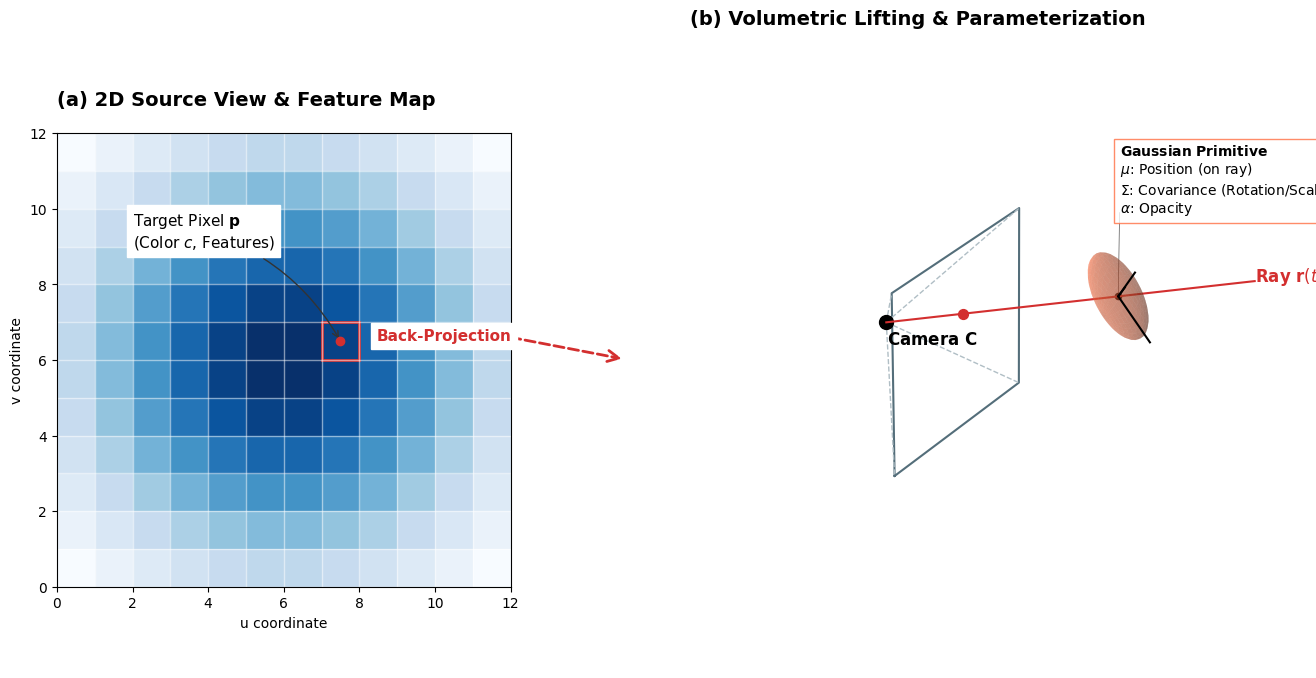

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np

def get_rotation_matrix(yaw, pitch, roll):
    """Helper to create a 3D rotation matrix."""
    cy, sy = np.cos(yaw), np.sin(yaw)
    cp, sp = np.cos(pitch), np.sin(pitch)
    cr, sr = np.cos(roll), np.sin(roll)
    
    R_yaw = np.array([[cy, -sy, 0], [sy, cy, 0], [0, 0, 1]])
    R_pitch = np.array([[cp, 0, sp], [0, 1, 0], [-sp, 0, cp]])
    R_roll = np.array([[1, 0, 0], [0, cr, -sr], [0, sr, cr]])
    
    return R_yaw @ R_pitch @ R_roll

def draw_gaussian_primitive(ax, center, radii, rotation_matrix, color, alpha_val):
    """
    Draws a 3D Gaussian primitive with internal axes to denote Covariance (Sigma).
    """
    # 1. Draw the Ellipsoid Surface
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))
    
    points = np.stack([x.flatten(), y.flatten(), z.flatten()])
    rot_points = rotation_matrix @ points
    
    x_rot = rot_points[0, :].reshape(x.shape) + center[0]
    y_rot = rot_points[1, :].reshape(y.shape) + center[1]
    z_rot = rot_points[2, :].reshape(z.shape) + center[2]
    
    # Outer Shell (Opacity visualization)
    ax.plot_surface(x_rot, y_rot, z_rot, color=color, alpha=alpha_val, 
                    rstride=1, cstride=1, linewidth=0, antialiased=True, shade=True)
    
    # Wireframe to emphasize shape
    ax.plot_wireframe(x_rot, y_rot, z_rot, color='white', alpha=0.1, 
                      rstride=5, cstride=5, linewidth=0.5)

    # 2. Draw Eigenvectors (Covariance/Rotation visualization)
    # The axes of the ellipsoid
    for i in range(3):
        # Scale eigenvector by radius
        vec = rotation_matrix[:, i] * radii[i] * 1.2 # slightly longer than radius
        
        # Draw axis line
        ax.plot([center[0], center[0] + vec[0]], 
                [center[1], center[1] + vec[1]], 
                [center[2], center[2] + vec[2]], 
                color='black', lw=1.5, zorder=100)
    
    # Draw Center point (Mu)
    ax.scatter(center[0], center[1], center[2], color='black', s=20, zorder=101)

def plot_improved_lifting():
    # Setup Figure
    fig = plt.figure(figsize=(18, 8), facecolor='white')
    
    # GridSpec for layout
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 2], wspace=0.05)
    
    # ==========================
    # PANEL A: 2D Feature Map
    # ==========================
    ax2d = fig.add_subplot(gs[0])
    ax2d.set_title("(a) 2D Source View & Feature Map", fontsize=14, fontweight='bold', loc='left', pad=20)
    
    # Generate synthetic "feature" data
    grid_size = 12
    x = np.linspace(-1, 1, grid_size)
    y = np.linspace(-1, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.exp(-(X**2 + Y**2)) # Gaussian blob features
    
    # Plot heatmap
    im = ax2d.imshow(Z, cmap='Blues', extent=[0, grid_size, 0, grid_size], origin='lower')
    
    # Draw Pixel Grid
    for i in range(grid_size + 1):
        ax2d.axhline(i, color='white', lw=1, alpha=0.5)
        ax2d.axvline(i, color='white', lw=1, alpha=0.5)
        
    # Highlight Target Pixel
    target_x, target_y = 7.5, 6.5 # Center of pixel (7,6)
    rect = patches.Rectangle((7, 6), 1, 1, linewidth=2, edgecolor='#D32F2F', facecolor='none')
    ax2d.add_patch(rect)
    ax2d.scatter(target_x, target_y, color='#D32F2F', zorder=10)
    
    # Annotate Pixel
    ax2d.annotate(r"Target Pixel $\mathbf{p}$" + "\n(Color $c$, Features)", 
                  xy=(target_x, target_y), xytext=(2, 9),
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-0.2", color='#333'),
                  fontsize=11, backgroundcolor='white')

    ax2d.set_xlabel("u coordinate")
    ax2d.set_ylabel("v coordinate")
    ax2d.set_aspect('equal')

    # ==========================
    # PANEL B: 3D Volumetric Scene
    # ==========================
    ax3d = fig.add_subplot(gs[1], projection='3d')
    ax3d.set_title("(b) Volumetric Lifting & Parameterization", fontsize=14, fontweight='bold', loc='left', pad=20)
    
    # Camera Settings
    ax3d.view_init(elev=25, azim=-60)
    ax3d.set_xlim(-2, 12)
    ax3d.set_ylim(-4, 4)
    ax3d.set_zlim(-3, 3)
    ax3d.axis('off') # Turn off standard axis for cleaner look

    # 1. Draw Frustum / Camera
    cam_origin = np.array([0, 0, 0])
    image_plane_x = 3.0
    
    # Draw Camera Center
    ax3d.scatter(0, 0, 0, s=100, c='black', label='Camera Center')
    ax3d.text(0, 0, -0.5, r"Camera $\mathbf{C}$", fontsize=12, fontweight='bold')
    
    # Draw Image Plane Rect
    y_ext, z_ext = 2.5, 2.0
    y_corners = np.array([-y_ext, y_ext, y_ext, -y_ext, -y_ext])
    z_corners = np.array([-z_ext, -z_ext, z_ext, z_ext, -z_ext])
    x_corners = np.full_like(y_corners, image_plane_x)
    
    # Plane outline
    ax3d.plot(x_corners, y_corners, z_corners, color='#546E7A', lw=1.5)
    # Frustum lines (Camera to Plane corners)
    for i in range(4):
        ax3d.plot([0, image_plane_x], [0, y_corners[i]], [0, z_corners[i]], color='#B0BEC5', ls='--', lw=1)
    
    # 2. Draw The Ray
    # Calculate ray direction based on our 2D pixel selection
    # Map 2D (0-12) to 3D Plane coordinates
    ray_y = ((target_y / grid_size) - 0.5) * 2 * y_ext
    ray_z = ((target_x / grid_size) - 0.5) * 2 * z_ext
    
    ray_dir = np.array([image_plane_x, ray_y, ray_z])
    ray_dir = ray_dir / np.linalg.norm(ray_dir) # Normalize
    
    ray_end = ray_dir * 14 # Ray length
    
    # Draw Ray Line
    ax3d.plot([0, ray_end[0]], [0, ray_end[1]], [0, ray_end[2]], color='#D32F2F', lw=1.5, zorder=5)
    ax3d.text(ray_end[0], ray_end[1], ray_end[2], r"Ray $\mathbf{r}(t)$", color='#D32F2F', fontsize=12, fontweight='bold')

    # Draw Intersection point on Image Plane
    plane_intersect = ray_dir * (image_plane_x / ray_dir[0])
    ax3d.scatter(plane_intersect[0], plane_intersect[1], plane_intersect[2], c='#D32F2F', s=50, zorder=10)
    
    # 3. Draw 3D Gaussian Primitive
    # Params
    g_center = ray_dir * 9.0 # Distance along ray
    g_radii = [1.2, 0.4, 0.6] # Anisotropic scale
    g_rot = get_rotation_matrix(np.radians(20), np.radians(45), 0)
    
    draw_gaussian_primitive(ax3d, g_center, g_radii, g_rot, '#FF7043', 0.4)
    
    # 4. Annotations for Gaussian Parameters
    # Offset text slightly from the Gaussian center
    text_pos = g_center + np.array([0, 0, 1.8])
    
    annotation_text = (
        r"$\mathbf{Gaussian\ Primitive}$" + "\n" +
        r"$\mu$: Position (on ray)" + "\n" +
        r"$\Sigma$: Covariance (Rotation/Scale)" + "\n" +
        r"$\alpha$: Opacity"
    )
    ax3d.text(text_pos[0], text_pos[1], text_pos[2], annotation_text, 
              fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='#FF7043'))
    
    # Connect label to center
    ax3d.plot([g_center[0], text_pos[0]], [g_center[1], text_pos[1]], [g_center[2], text_pos[2]], c='#555', lw=0.5)

    # ==========================
    # CROSS-PANEL CONNECTION
    # ==========================
    # We use ConnectionPatch to draw a line from the 2D pixel to the 3D plane intersection
    # Note: 3D coordinates in Matplotlib are tricky to link to 2D figures. 
    # We visually fake it by drawing an arrow between the subplot boundaries.
    
    con = ConnectionPatch(xyA=(target_x, target_y), xyB=(image_plane_x, 0), # connecting to approx projection
                          coordsA="data", coordsB="data",
                          axesA=ax2d, axesB=ax3d,
                          color="#D32F2F", arrowstyle="-|>", mutation_scale=20, lw=2, linestyle="dashed")
    
    # Since linking 2D data to specific 3D projected points is unstable in static matplotlib,
    # We anchor the arrow to the left side of the 3D plot box
    con_visual = ConnectionPatch(
        xyA=(1.0, 0.55), coordsA=ax2d.transAxes,
        xyB=(-0.1, 0.5), coordsB=ax3d.transAxes,
        arrowstyle="->", shrinkB=5, color="#D32F2F", lw=2, mutation_scale=20, linestyle="--"
    )
    fig.add_artist(con_visual)
    
    # Add text over the arrow
    fig.text(0.34, 0.52, "Back-Projection", color="#D32F2F", fontsize=11, fontweight='bold', ha='center', backgroundcolor='white')

    plt.tight_layout()
    plt.savefig('improved_volumetric_lifting.png', dpi=150)
    plt.show()

plot_improved_lifting()

/tmp/ipykernel_2419552/3136713460.py:180: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.1, 1, 0.95])


SVG generated successfully: 'volumetric_lifting.svg'


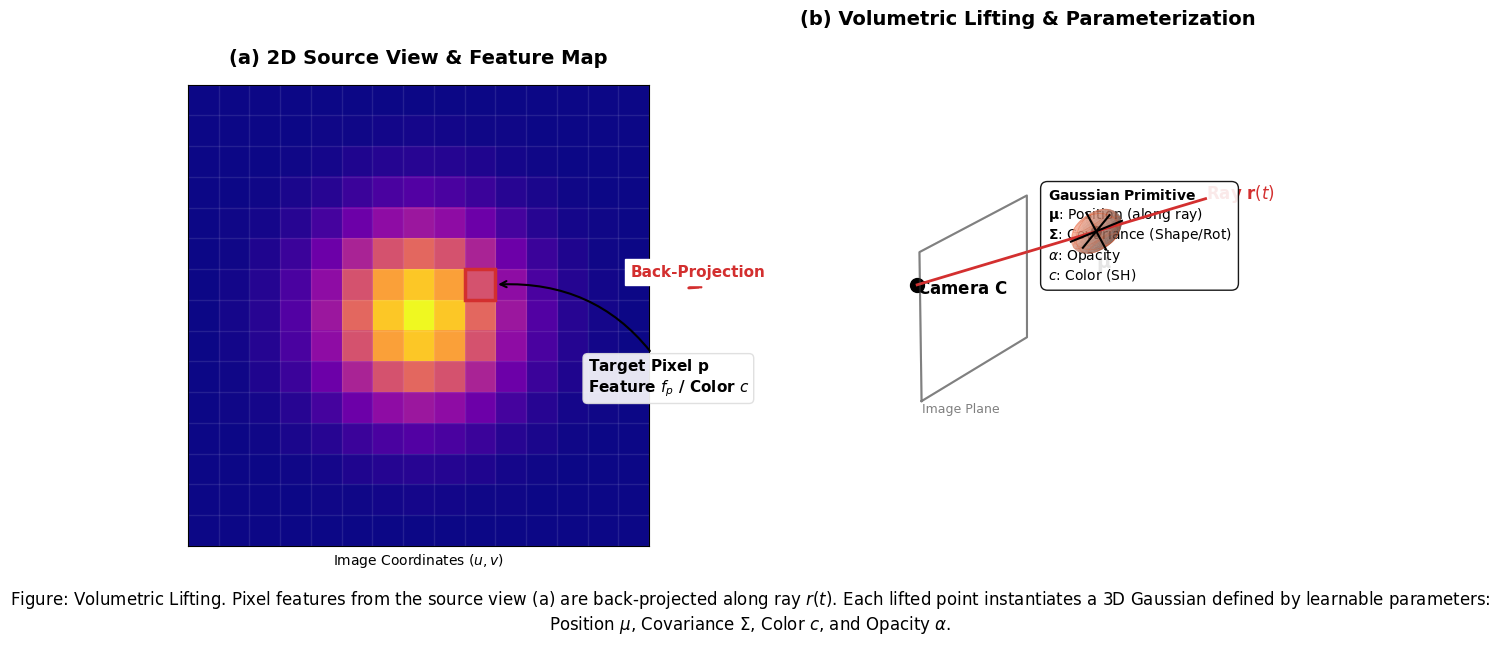

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Set params for SVG export to ensure text is editable/searchable
plt.rcParams['svg.fonttype'] = 'none'

def get_rotation_matrix(yaw, pitch, roll):
    """Generates a 3D rotation matrix."""
    cy, sy = np.cos(yaw), np.sin(yaw)
    cp, sp = np.cos(pitch), np.sin(pitch)
    cr, sr = np.cos(roll), np.sin(roll)
    
    R_yaw = np.array([[cy, -sy, 0], [sy, cy, 0], [0, 0, 1]])
    R_pitch = np.array([[cp, 0, sp], [0, 1, 0], [-sp, 0, cp]])
    R_roll = np.array([[1, 0, 0], [0, cr, -sr], [0, sr, cr]])
    return R_yaw @ R_pitch @ R_roll

def plot_illustration():
    fig = plt.figure(figsize=(15, 7))
    
    # Create Grid Layout
    gs = fig.add_gridspec(1, 2, width_ratios=[1, 1.4], wspace=0.1)

    # ==========================================
    # PANEL A: 2D Source View (Pixel Features)
    # ==========================================
    ax2d = fig.add_subplot(gs[0])
    ax2d.set_title("(a) 2D Source View & Feature Map", fontsize=14, fontweight='bold', pad=15)
    
    # Create synthetic feature map (Yellow blob on Blue bg)
    grid_size = 15
    y, x = np.mgrid[-2:2:complex(0, grid_size), -2:2:complex(0, grid_size)]
    z = np.exp(-(x**2 + y**2) * 1.5) # Gaussian blob
    
    # Plot heatmap
    ax2d.imshow(z, cmap='plasma', interpolation='nearest', extent=[0, grid_size, 0, grid_size], origin='lower')
    
    # Grid lines
    for i in range(grid_size + 1):
        ax2d.axhline(i, color='white', alpha=0.1, lw=1)
        ax2d.axvline(i, color='white', alpha=0.1, lw=1)
    
    # Highlight Target Pixel
    px, py = 9, 8 # Coordinates
    rect = patches.Rectangle((px, py), 1, 1, linewidth=2.5, edgecolor='#D32F2F', facecolor='none', zorder=5)
    ax2d.add_patch(rect)
    
    # Label: Target Pixel
    ax2d.annotate(r"Target Pixel $\mathbf{p}$" + "\n" + r"Feature $f_p$ / Color $c$", 
                  xy=(px+1, py+0.5), xytext=(px+4, py-3),
                  arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0.3", color='black', lw=1.5),
                  fontsize=11, fontweight='bold', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="#ddd", alpha=0.9))
    
    ax2d.set_xticks([])
    ax2d.set_yticks([])
    ax2d.set_xlabel("Image Coordinates $(u, v)$", fontsize=10)

    # ==========================================
    # PANEL B: 3D Volumetric Lifting
    # ==========================================
    ax3d = fig.add_subplot(gs[1], projection='3d')
    ax3d.set_title("(b) Volumetric Lifting & Parameterization", fontsize=14, fontweight='bold', pad=15)
    
    # Clean 3D pane
    ax3d.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax3d.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax3d.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax3d.grid(False)
    ax3d.axis('off')

    # 1. Camera
    ax3d.scatter([0], [0], [0], color='black', s=100, zorder=10)
    ax3d.text(0, 0, -0.4, r"Camera $\mathbf{C}$", fontsize=12, fontweight='bold')

    # 2. Image Plane
    plane_dist = 4
    y_plane = np.linspace(-3, 3, 2)
    z_plane = np.linspace(-3, 3, 2)
    Y, Z = np.meshgrid(y_plane, z_plane)
    X = np.full_like(Y, plane_dist)
    ax3d.plot_wireframe(X, Y, Z, alpha=0.2, color='gray')
    # Draw border
    ax3d.plot([plane_dist]*5, [-3, 3, 3, -3, -3], [-3, -3, 3, 3, -3], color='gray', lw=1.5)
    ax3d.text(plane_dist, -3, -3.5, "Image Plane", fontsize=9, color='gray')

    # 3. Ray Casting
    # Calculate vector from Camera (0,0,0) through Pixel projected on Plane
    # Mapping pixel (9,8) roughly to plane coordinates
    ray_y = 1.0 
    ray_z = 1.0
    ray_dir = np.array([plane_dist, ray_y, ray_z])
    ray_dir = ray_dir / np.linalg.norm(ray_dir) # normalize
    ray_len = 16
    ray_end = ray_dir * ray_len
    
    # Draw Ray
    ax3d.plot([0, ray_end[0]], [0, ray_end[1]], [0, ray_end[2]], color='#D32F2F', lw=2, zorder=5)
    ax3d.text(ray_end[0], ray_end[1], ray_end[2], r"Ray $\mathbf{r}(t)$", color='#D32F2F', fontsize=12, fontweight='bold')

    # 4. Gaussian Primitive (Ellipsoid)
    # Center it further down the ray
    center_dist = 10
    mu = ray_dir * center_dist
    
    # Ellipsoid Geometry
    radii = [1.5, 0.8, 0.8] # Anisotropic scale
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 20)
    x = radii[0] * np.outer(np.cos(u), np.sin(v))
    y = radii[1] * np.outer(np.sin(u), np.sin(v))
    z = radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))
    
    # Rotate (align roughly with ray + some variance)
    R = get_rotation_matrix(0, np.radians(-20), np.radians(20))
    points = np.stack([x.flatten(), y.flatten(), z.flatten()])
    rot_points = R @ points
    
    x_rot = rot_points[0, :].reshape(x.shape) + mu[0]
    y_rot = rot_points[1, :].reshape(y.shape) + mu[1]
    z_rot = rot_points[2, :].reshape(z.shape) + mu[2]
    
    # Draw Surface (Opacity Alpha)
    ax3d.plot_surface(x_rot, y_rot, z_rot, color='#FFAB91', alpha=0.6, rstride=1, cstride=1, shade=True, linewidth=0)
    ax3d.plot_wireframe(x_rot, y_rot, z_rot, color='#E64A19', alpha=0.3, rstride=5, cstride=5, linewidth=0.5)

    # 5. Visualize Covariance Axes (Sigma) inside
    axis_len_scale = 1.2
    colors = ['black', 'black', 'black']
    for i in range(3):
        axis_vec = R[:, i] * radii[i] * axis_len_scale
        ax3d.plot([mu[0]-axis_vec[0], mu[0]+axis_vec[0]],
                  [mu[1]-axis_vec[1], mu[1]+axis_vec[1]],
                  [mu[2]-axis_vec[2], mu[2]+axis_vec[2]], color=colors[i], lw=1.5, zorder=20)

    # Label: Center Mu
    ax3d.scatter(mu[0], mu[1], mu[2], color='black', s=50, zorder=25)
    ax3d.text(mu[0], mu[1], mu[2]-1.5, r"$\mathbf{\mu}$", fontsize=14, fontweight='bold', color='black')

    # 6. Parameter Explanation Text
    param_text = (
        r"$\bf{Gaussian\ Primitive}$" + "\n" +
        r"$\mathbf{\mu}$: Position (along ray)" + "\n" +
        r"$\mathbf{\Sigma}$: Covariance (Shape/Rot)" + "\n" +
        r"$\alpha$: Opacity" + "\n" +
        r"$c$: Color (SH)"
    )
    ax3d.text(2, 6, -2, param_text, fontsize=10, 
              bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="black", alpha=0.9))

    # ==========================================
    # Connection (Back-Projection Arrow)
    # ==========================================
    # Connect 2D pixel to 3D image plane intersection
    # Visual coordinates for connection patch
    con = ConnectionPatch(xyA=(1.02, 0.6), coordsA=ax2d.transAxes,
                          xyB=(-0.1, 0.55), coordsB=ax3d.transAxes,
                          arrowstyle="-|>", color="#D32F2F", lw=2, linestyle="--", mutation_scale=20)
    fig.add_artist(con)
    fig.text(0.42, 0.55, "Back-Projection", color="#D32F2F", fontsize=11, fontweight='bold', backgroundcolor='white')

    # ==========================================
    # Caption
    # ==========================================
    caption = (
        "Figure: Volumetric Lifting. Pixel features from the source view (a) are back-projected along ray $r(t)$. "
        "Each lifted point instantiates a 3D Gaussian defined by learnable parameters: "
        "Position $\mu$, Covariance $\Sigma$, Color $c$, and Opacity $\\alpha$."
    )
    fig.text(0.5, 0.05, caption, ha='center', fontsize=12, wrap=True)

    # Adjust layout
    ax3d.view_init(elev=20, azim=-60)
    ax3d.set_ylim(-5, 5)
    ax3d.set_zlim(-5, 5)
    ax3d.set_xlim(-2, 18)
    
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])
    
    # Save as SVG
    plt.savefig('volumetric_lifting.svg', format='svg', dpi=300)
    print("SVG generated successfully: 'volumetric_lifting.svg'")
    plt.show()

plot_illustration()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle, ConnectionPatch
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap

# --- Helper Functions ---

def generate_heatmap_data(size, center, sigma):
    """Generates a 2D Gaussian blob for the heatmap."""
    x = np.arange(0, size)
    y = np.arange(0, size)
    X, Y = np.meshgrid(x, y)
    # Create a large, slightly off-center blob
    Z = np.exp(-((X - center[0])**2 / (2 * sigma[0]**2) + 
                 (Y - center[1])**2 / (2 * sigma[1]**2)))
    # Add some noise and a background gradient to make it look like the image
    noise = np.random.rand(size, size) * 0.1
    background = np.linspace(0, 0.3, size)[:, None] * np.linspace(0, 0.3, size)[None, :]
    return Z + noise + background

def get_ellipsoid_data(center, radii, rotation_matrix):
    """Generates surface data for a 3D ellipsoid."""
    u = np.linspace(0, 2 * np.pi, 50)
    v = np.linspace(0, np.pi, 50)
    
    # Unit sphere
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones_like(u), np.cos(v))
    
    # Scale, rotate, and translate
    for i in range(len(x)):
        for j in range(len(x)):
            [x[i,j], y[i,j], z[i,j]] = np.dot(rotation_matrix, 
                                              [x[i,j]*radii[0], 
                                               y[i,j]*radii[1], 
                                               z[i,j]*radii[2]]) + center
    return x, y, z

# --- Main Plotting Script ---

# Create figure and subplots
fig = plt.figure(figsize=(12, 5))

# ==============================================================================
# Left Panel: (a) 2D Source View & Feature Map
# ==============================================================================
ax1 = fig.add_subplot(121)

# 1. Generate and plot the heatmap
grid_size = 20
heatmap_data = generate_heatmap_data(size=grid_size, center=(10, 9), sigma=(4, 5))

# Custom colormap to match the image (blue -> cyan -> yellow)
colors = [(0, 0, 0.5), (0, 0.5, 1), (0, 1, 1), (1, 1, 0)]
cmap_name = 'custom_blue_yellow'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)

im = ax1.imshow(heatmap_data, cmap=cm, interpolation='nearest', origin='upper')

# 2. Add the target pixel highlight (red square)
target_x, target_y = 12, 8 # Coordinates for the red box
rect = Rectangle((target_x - 0.5, target_y - 0.5), 1, 1, 
                 linewidth=2, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

# 3. Add labels and annotations
ax1.text(target_x - 3, target_y + 2, 'Target Pixel $\mathbf{p}$\n$(u, v), c$', 
         color='black', fontsize=12, ha='left')

# Dashed line for back-projection (extends out of the plot)
line_start = (target_x + 0.5, target_y)
line_end = (grid_size + 5, target_y) # Point outside the axes
ax1.plot([line_start[0], line_end[0]], [line_start[1], line_end[1]], 
         color='r', linestyle='--', linewidth=2, clip_on=False)
ax1.text(grid_size + 1, target_y - 1, 'Back-Projection', color='black', fontsize=12)

# 4. Styling
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(a) 2D Source View & Feature Map', y=-0.1, fontsize=14)

# ==============================================================================
# Right Panel: (b) Volumetric Lifting & Parameterization
# ==============================================================================
ax2 = fig.add_subplot(122, projection='3d')

# 1. Define 3D geometry
camera_origin = np.array([0, 0, 0])
image_plane_z = 2
ray_direction = np.array([1.5, 0.8, image_plane_z]) # Ray passes through image plane
ray_direction = ray_direction / np.linalg.norm(ray_direction)
ellipsoid_center = ray_direction * 6 # Place ellipsoid along the ray

# 2. Plot Camera
ax2.scatter(*camera_origin, color='black', s=100, label='Camera C')
ax2.text(0, 0, -0.5, 'Camera $\mathbf{C}$', fontsize=12, ha='center')

# 3. Plot Image Plane
xx, yy = np.meshgrid(np.linspace(-1, 2, 2), np.linspace(-1, 2, 2))
zz = np.full_like(xx, image_plane_z)
ax2.plot_surface(xx, yy, zz, color='gray', alpha=0.2, edgecolor='gray')
ax2.text(0.5, -1.2, image_plane_z, 'Image Plane', fontsize=12)

# 4. Plot Ray
ray_end = ray_direction * 8
ax2.plot([camera_origin[0], ray_end[0]], 
         [camera_origin[1], ray_end[1]], 
         [camera_origin[2], ray_end[2]], 'r-', linewidth=2)
ax2.text(ray_end[0], ray_end[1], ray_end[2], 'Ray $\mathbf{r}(t)$', fontsize=12)

# 5. Plot Gaussian Primitive (Ellipsoid)
radii = [1.2, 0.6, 0.6] # Stretched along one axis
# Rotation matrix to align the major axis with the ray and tilt it
# A simple way is to construct a basis from the ray direction
v1 = ray_direction
v2 = np.cross(v1, [0, 1, 0]) # Arbitrary vector to get an orthogonal one
v2 = v2 / np.linalg.norm(v2)
v3 = np.cross(v1, v2)
rotation_matrix = np.column_stack((v1, v2, v3))

ex, ey, ez = get_ellipsoid_data(ellipsoid_center, radii, rotation_matrix)
ax2.plot_surface(ex, ey, ez, color='orange', alpha=0.6, edgecolor='darkorange', linewidth=0.5)

# 6. Add Ellipsoid Axes (Quivers)
# We need to plot the rotated axes
for i, radius in enumerate(radii):
    # Get the direction of the i-th principal axis from the rotation matrix
    axis_dir = rotation_matrix[:, i]
    # Start at center, end at center + radius * direction
    ax2.quiver(*ellipsoid_center, *axis_dir, length=radius, 
               color='black', linewidth=1.5, arrow_length_ratio=0.2)

# 7. Add Annotations
ax2.text(*ellipsoid_center, '$\mathbf{\mu}$', fontsize=14, color='black', ha='center', va='center')

# Back-projection line "arriving" at the ellipsoid
# We'll draw it from outside the plot towards the center
line_start_3d = ellipsoid_center - np.array([4, 0, 0]) # Arbitrary point to the left
ax2.plot([line_start_3d[0], ellipsoid_center[0]],
         [line_start_3d[1], ellipsoid_center[1]],
         [line_start_3d[2], ellipsoid_center[2]],
         'r--', linewidth=2)

# 8. Add the explanatory text block
text_x = 5
text_y = -3
text_z = 2

# Use raw strings (r'...') for LaTeX to prevent Python from escaping \alpha and \mu
label_text = (
    'Gaussian Primitive:\n'
    r'$\boldsymbol{\mu}$: Position (on ray)' + '\n'
    r'$\boldsymbol{\Sigma}$: Covariance' + '\n'
    '   (Rotation/Scale)\n'
    r'$\boldsymbol{\alpha}$: Opacity'
)

ax2.text(text_x, text_y, text_z, 
         label_text,
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.0, edgecolor='none'))

# 9. Styling
ax2.set_xlim(-1, 7)
ax2.set_ylim(-3, 3)
ax2.set_zlim(-1, 7)
ax2.set_axis_off() # Hide axes for a cleaner diagram look
ax2.view_init(elev=20, azim=-45) # Set the camera angle to match the diagram
ax2.set_title('(b) Volumetric Lifting & Parameterization', y=-0.05, fontsize=14)

# Final layout adjustments
plt.tight_layout()
plt.subplots_adjust(wspace=0.1) # Adjust space between subplots

plt.show()

ValueError: 
\mathbf{lpha}
^
ParseFatalException: Unknown symbol: \mathbf, found '\'  (at char 0), (line:1, col:1)

<Figure size 1200x500 with 2 Axes>